In [1]:
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scvi
import scanpy as sc

%load_ext nb_black
use_cuda = True


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
data_path = "../TabulaSapiensData/"

In [4]:
adata = read_h5ad(data_path + "decontX/Pilot1_Pilot2.decontX.h5ad")

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)
/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


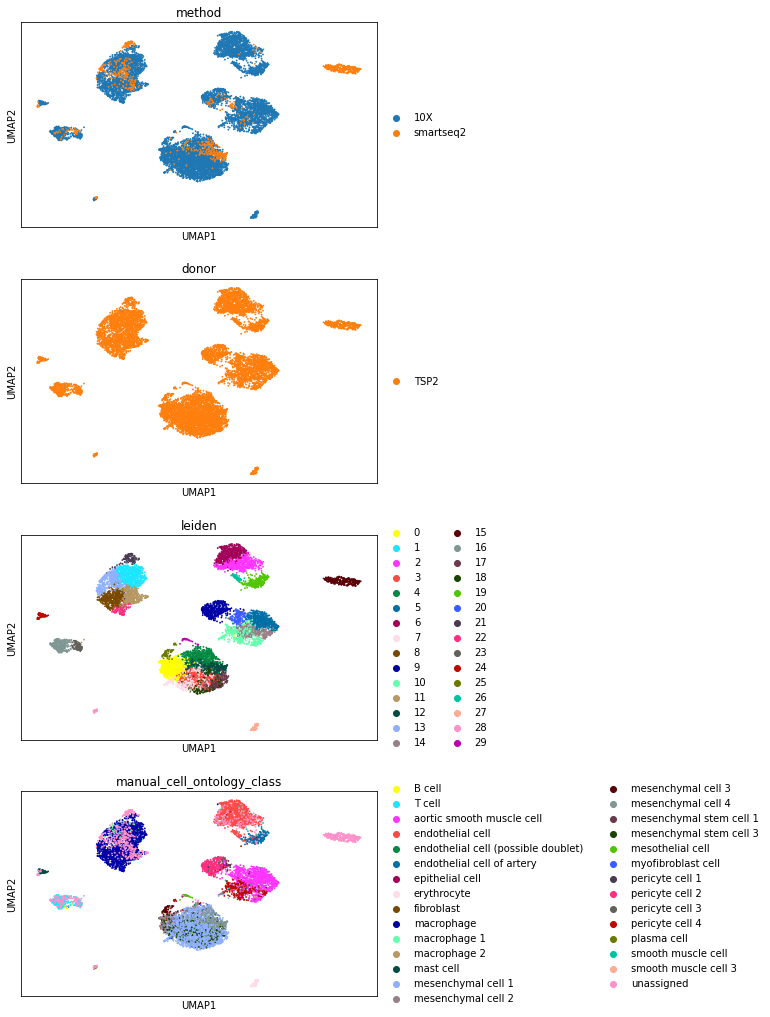

In [5]:
organ = "Vasculature"
organ_adata = adata[adata.obs["tissue"] == organ]
sc.pp.neighbors(organ_adata, use_rep="X_scvi_decontX")
sc.tl.umap(organ_adata)
organ_adata.obsm["X_umap_decontX"] = organ_adata.obsm["X_umap"].copy()
sc.tl.leiden(organ_adata, resolution=2)
sc.pl.umap(
    organ_adata,
    color=["method", "donor", "leiden", "manual_cell_ontology_class"],
    ncols=1,
)
organ_adata.X = np.log1p(organ_adata.X)

# cluster to celltype correspondance
count is a matrix of cluster-cell type correspondance, where each row is a celltype, and each colum is a cluster. The entries to the matrix is the number of cells that is annotated as celltype *X* and cluster *Y*

In [6]:
count = {}
for c in np.unique(organ_adata.obs["leiden"]):
    count[c] = {}
    for t in np.unique(organ_adata.obs["manual_cell_ontology_class"]):
        count[c][t] = np.sum(
            (organ_adata.obs["leiden"].astype(str) == c)
            & (organ_adata.obs["manual_cell_ontology_class"] == t)
        )

count = pd.DataFrame.from_dict(count)

We can visualize the cluster assignment of each cell type through this heatmap. The color is normalized for each celltype 

<AxesSubplot:>

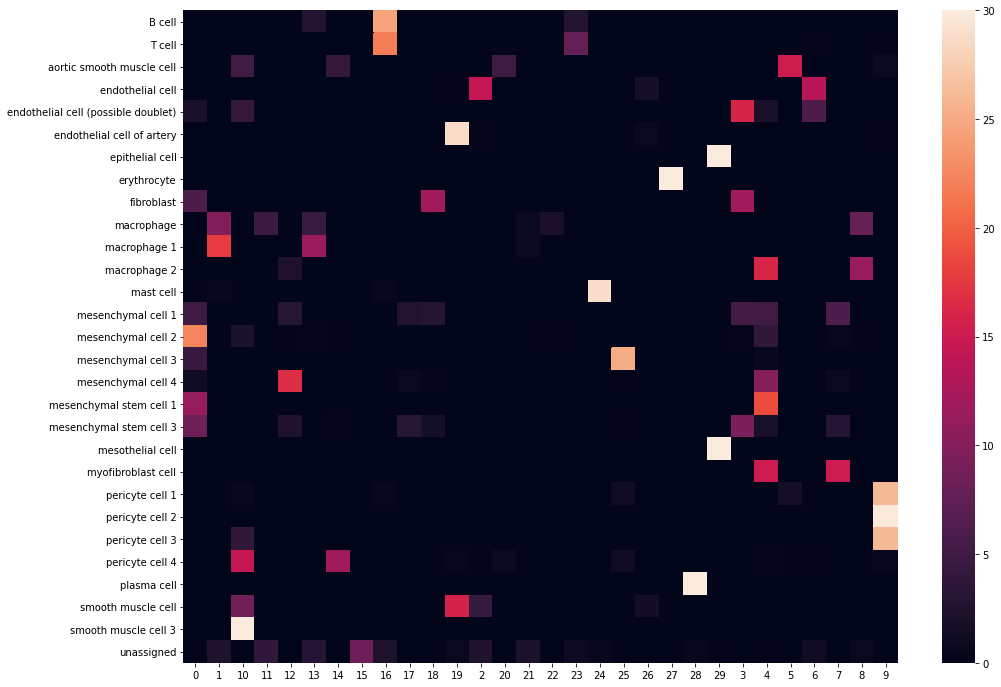

In [7]:
import seaborn

plt.figure(figsize=(16, 12))
seaborn.heatmap((count.T / count.mean(axis=1)).T)

# dictionary of cell type composition of each cluster 
What are clusters previously annotated as 

In [8]:
cluster_composition = {}
for x in count.columns.values:
    t = count.index[count[x] > 0].values
    freq = np.asarray([count.loc[y, x] for y in t]) / count[x].sum()
    res = [a + ": %.2f" % b for a, b in zip(t, freq)]
    cluster_composition[x] = res

In [9]:
cluster_composition["0"]

['endothelial cell (possible doublet): 0.00',
 'fibroblast: 0.00',
 'mesenchymal cell 1: 0.52',
 'mesenchymal cell 2: 0.24',
 'mesenchymal cell 3: 0.01',
 'mesenchymal cell 4: 0.01',
 'mesenchymal stem cell 1: 0.00',
 'mesenchymal stem cell 3: 0.20',
 'pericyte cell 4: 0.00',
 'unassigned: 0.00']

# Reassign pure clusters
If a cluster is very pure (>95% of annotated cells come from the same celltype, we reassign the clusters to all have the same labels) 

In [10]:
def Purity(x):
    names = x.index
    x = np.asarray(x).ravel()
    x = x[names != "unassigned"]
    return (np.max(x) / np.sum(x), names[np.argmax(x)])

In [11]:
cluster_purity = count.apply(Purity, axis=0).T
confident_clusters = cluster_purity[cluster_purity[0] > 0.95].index

<ipython-input-1-963029a66ab7>:5: RuntimeWarning: invalid value encountered in long_scalars
  return (np.max(x) / np.sum(x), names[np.argmax(x)])


In [12]:
for i in confident_clusters:
    organ_adata.obs.loc[
        organ_adata.obs["leiden"] == i, "new_manual_cell_ontology_class"
    ] = cluster_purity.loc[i, 1]

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'new_manual_cell_ontology_class' as categorical


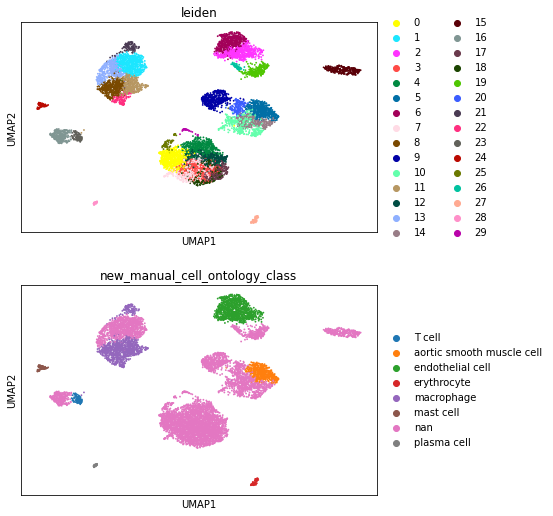

In [13]:
sc.pl.umap(
    organ_adata,
    color=["leiden", "new_manual_cell_ontology_class"],
    ncols=1,
)

# Sankey Diagram between cluster and cell types

In [14]:
from utils.colorDict import donor_colors, method_colors, compartment_colors, tissue_colors

In [15]:
from utils.plotting_utils import *
from utils.colorDict import compartment_colors

import plotly
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly.io as pio

pio.renderers.default = "notebook"

init_notebook_mode(connected=True)

In [16]:
df = pd.DataFrame(columns=["celltype", "compartment", "count"])
for t in np.unique(organ_adata.obs["manual_cell_ontology_class"]):
    for c in np.unique(organ_adata.obs["compartment_pred_svm"]):
        x = np.sum(
            (organ_adata.obs["compartment_pred_svm"].astype(str) == c)
            & (organ_adata.obs["manual_cell_ontology_class"] == t)
        )
        df = df.append(
            pd.DataFrame([t, c, x], index=["celltype", "compartment", "count"]).T,
            ignore_index=True,
        )


fig = genSankey(
    df,
    cat_cols_color=[compartment_colors(), "#00A1E0"],
    cat_cols=["compartment", "celltype"],
    value_cols="count",
    title="celltype-compartment",
)
iplot(fig, validate=False)
plotly.offline.plot(
    fig, validate=False, filename="figures/celltype_sankey_%s" % organ + ".html"
)  # , output_type='div')

'figures/celltype_sankey_Vasculature.html'

# visualize compartment markers

In [17]:
compartment_markers = {
    "Epithelial": ["CDH1", "CLDN4", "EPCAM"],
    "Endothelial": ["CA4", "CDH5", "CLDN5", "PECAM1", "VWF"],
    "Stromal": ["BGN", "DCN", "COL1A2"],
    "Immune": ["LCP1", "PTPRC", "RAC2"],
}

In [18]:
for x in compartment_markers.keys():
    sc.tl.score_genes(organ_adata, compartment_markers[x], score_name="%s_score" % x)

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



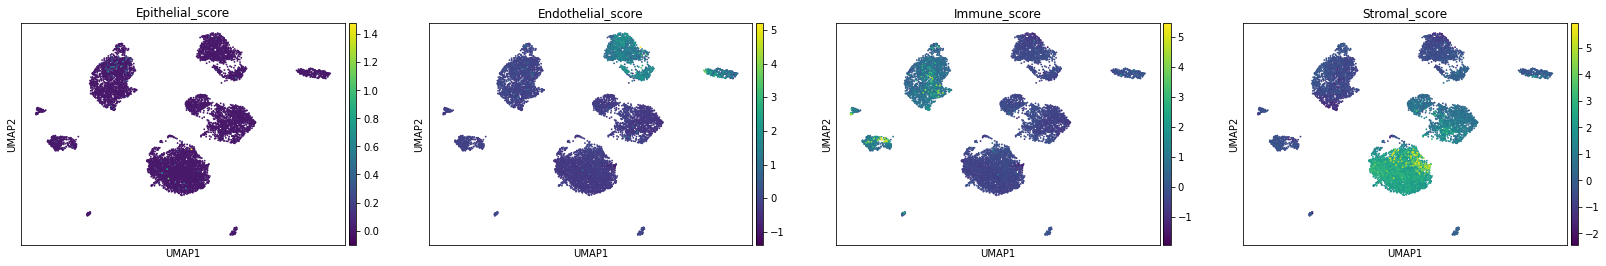

In [19]:
sc.pl.umap(
    organ_adata,
    color=["Epithelial_score", "Endothelial_score", "Immune_score", "Stromal_score"],
)

# Find markers for each cluster

In [20]:
sc.tl.rank_genes_groups(organ_adata, groupby="leiden", method="wilcoxon")

In [21]:
def FormatDE(res):
    groups = res['scores'].dtype.names
    df_res = {}
    for group in groups:
        df = pd.DataFrame([res['scores'][group],
                           res['logfoldchanges'][group],res['pvals_adj'][group]], 
                           columns=res['names'][group],
                           index=['wilcoxon_score','log fold change','adjusted pvalue'])
        df_res[group] = df
    return df_res


In [22]:
DE = FormatDE(organ_adata.uns["rank_genes_groups"])

### top positive marker genes

In [23]:
for x in DE.keys():
    print(x)
    display(DE[x].T[:20])

0


wilcoxon_score  log fold change  adjusted pvalue
SERPINF1       34.297207         4.121323    5.084276e-253
COL6A3         32.768597         3.396478    4.857053e-231
PRRX1          32.482800         3.099557    3.660727e-227
SPOCK1         32.251904         3.284850    4.868929e-224
C1S            32.030838         3.430645    4.778911e-221
SFRP2          31.969236         4.009863    2.864657e-220
C1R            31.948431         3.519609    4.777331e-220
APOD           31.764252         4.698852    1.485331e-217
PCOLCE         31.644648         2.897825    5.877009e-216
PODN           31.487259         3.257517    7.641371e-214
SRPX           31.224543         3.283438    2.648570e-210
IGF1           31.094242         4.187369    1.413515e-208
RARRES2        31.013634         3.097103    1.598800e-207
CRISPLD2       30.579557         2.916445    9.624962e-202
FBLN1          30.505877         4.227419    8.547222e-201
OLFML3         30.381002         3.051777    3.602420e-199
PDGFRA         30.321768         2.915417    2.050713e-198
MT1X           30.283262         3.379434    6.228478e-198
C7             30.213013         4.370994    4.951440e-197
SVEP1          30.171246         3.536225    1.662352e-196

1


wilcoxon_score  log fold change  adjusted pvalue
LYVE1          39.831425         6.511505     0.000000e+00
MRC1           37.743416         5.166672     0.000000e+00
VSIG4          37.603676         5.298666    3.673441e-305
S100A9         37.398365         5.596438    6.113910e-302
RNASE1         37.300045         5.634115    1.928854e-300
C1QA           37.092056         6.009985    3.701817e-297
MS4A6A         36.904797         4.869657    3.255515e-294
C1QC           36.499371         5.217374    8.349972e-288
F13A1          36.281643         5.393770    2.061238e-284
C1orf162       36.218479         4.425202    1.834626e-283
MS4A4A         36.135147         4.569271    3.407440e-282
C1QB           36.102291         5.688827    1.024250e-281
FOLR2          36.055393         4.733652    5.140801e-281
CD163          35.637859         5.366623    1.527891e-274
MAF            35.505543         3.737309    1.584300e-272
AIF1           35.295071         4.454378    2.571730e-269
EMB            35.161331         4.486615    2.702041e-267
FCER1G         35.121571         4.463855    1.033133e-266
VAMP8          35.112602         3.874443    1.341347e-266
TGFBI          34.906769         3.905160    1.727475e-263

2


wilcoxon_score  log fold change  adjusted pvalue
PLVAP         33.037254         4.696499    1.396000e-234
VWF           32.794399         4.802966    1.388639e-231
PECAM1        31.455311         3.767669    5.226650e-213
RAMP3         31.139091         4.328655    8.390590e-209
ACKR1         30.942301         5.191649    3.164311e-206
ADGRL4        30.527870         4.192523    9.354630e-201
SOX18         30.305126         4.186808    7.220698e-198
GIMAP7        30.042740         3.640287    1.776699e-194
EGFL7         29.817999         3.407764    1.344037e-191
CLEC14A       29.599493         3.749890    8.118159e-189
LIFR          29.518801         3.810623    8.104503e-188
NOSTRIN       28.840446         3.751712    2.807627e-179
AQP1          28.829233         3.440264    3.622052e-179
NPDC1         28.708672         2.838853    1.094122e-177
CAVIN2        28.543453         3.526515    1.172909e-175
PLAT          27.633591         3.022317    1.437479e-164
EMCN          27.433781         4.001312    3.193331e-162
TSPAN7        27.167618         3.354313    4.395999e-159
IFI27         27.095623         2.895923    2.967043e-158
ECSCR         26.845041         3.569047    2.363951e-155

3


wilcoxon_score  log fold change  adjusted pvalue
FBN1          32.390469         4.029448    2.200910e-225
SCARA5        32.045319         4.062889    7.508970e-221
MFAP5         31.782139         4.751647    2.242525e-217
FSTL1         31.179279         3.593375    2.994535e-209
UAP1          30.742773         3.331629    1.798346e-203
ADAMTS5       30.513517         3.907814    1.692064e-200
TNXB          30.391176         3.087855    6.042257e-199
FBLN2         30.231878         3.159554    6.645065e-197
CCDC80        30.095419         4.331654    3.638588e-195
CD248         29.967529         3.343362    1.531123e-193
SEMA3C        29.734301         3.313820    1.481159e-190
DCN           29.713404         5.742426    2.528564e-190
PCOLCE2       29.644072         3.253959    1.831308e-189
GAS1          29.505426         3.787602    1.031342e-187
MMP2          29.477362         3.391938    2.204355e-187
ACKR3         29.387558         3.498767    2.914035e-186
PDGFRL        29.083591         2.983468    2.004879e-182
CYBRD1        28.871496         2.510437    8.904362e-180
HTRA3         28.858257         3.549625    1.236770e-179
SMIM14        28.793676         2.437577    7.576233e-179

4


wilcoxon_score  log fold change  adjusted pvalue
C3             26.006313         3.973770    2.473371e-144
LAMA2          23.782249         2.739548    1.236620e-120
CCDC80         23.773354         3.373567    1.236620e-120
FBLN1          23.701643         4.007397    5.103684e-120
ABCA8          23.635107         2.769182    1.977473e-119
SFRP2          22.404732         3.041740    3.472558e-107
DCN            22.132988         5.034786    1.279586e-104
C1R            21.849369         3.104971    5.799863e-102
FBN1           21.635698         2.683114    4.896842e-100
ABI3BP         21.635534         2.740865    4.896842e-100
PODN           21.488747         2.549402     1.061765e-98
C1S            21.453173         3.014395     2.092540e-98
COL6A3         21.443357         2.513321     2.385241e-98
GPX3           21.160162         3.080526     9.354246e-96
SERPINF1       21.072636         3.134423     5.565649e-95
MFAP5          20.947750         3.249662     7.237589e-94
FBLN2          20.890545         2.508706     2.134746e-93
ABCA6          20.768198         2.489762     2.601079e-92
MMP2           20.558395         2.594180     1.905564e-90
SCARA5         20.481361         2.605700     8.850504e-90

5


wilcoxon_score  log fold change  adjusted pvalue
TPM2             35.714249         7.342304    1.398666e-274
PLN              35.609634         6.250283    2.925515e-273
MYL9             35.567368         5.828887    8.787420e-273
RGS5             35.538628         6.756442    1.832441e-272
RAMP1            35.427517         5.882944    7.581516e-271
PPP1R14A         35.404232         6.202529    1.442013e-270
MYH11            35.095100         5.997209    6.733283e-266
ACTA2            35.072712         7.434486    1.293155e-265
DSTN             35.067806         4.569299    1.365434e-265
ITGA8            35.062069         5.665306    1.502993e-265
TAGLN            34.759140         6.364861    5.397357e-261
CNN1             34.660412         5.741576    1.527142e-259
AP002956.1       34.150173         4.921898    6.019544e-252
CSRP1            34.117367         4.217903    1.714310e-251
SORBS1           34.060905         4.549308    1.098430e-250
FLNA             33.783527         4.062748    1.266721e-246
SLC25A4          33.777298         3.992070    1.471637e-246
LMOD1            33.711857         4.306401    1.267293e-245
MYLK             33.562149         4.552153    1.854891e-243
NEXN             33.223988         3.971989    1.427475e-238

6


wilcoxon_score  log fold change  adjusted pvalue
ACKR1         34.539280         6.818644    1.215641e-256
PLVAP         33.708439         5.557858    1.280036e-244
RAMP3         33.167488         5.352383    6.220009e-237
CAVIN2        32.565723         4.854208    1.846096e-228
ADGRL4        32.481014         5.140629    2.327750e-227
GIMAP7        32.454559         4.398664    4.583035e-227
SOCS3         32.371590         4.071329    5.797649e-226
NPDC1         32.319759         3.852818    2.716680e-225
VWF           32.267647         5.172008    1.301607e-224
SOX18         32.248943         5.142395    2.142974e-224
PECAM1        31.971540         4.470653    1.451523e-220
LIFR          31.821053         4.729112    1.624410e-218
CLEC14A       31.653048         4.646794    3.117914e-216
AQP1          31.482170         4.568075    6.407579e-214
PCAT19        31.424070         5.642019    3.725430e-213
ECSCR         31.389774         4.783532    1.026632e-212
EMCN          31.292101         5.010605    2.069611e-211
IFI27         31.207554         4.025702    2.752223e-210
TSPAN7        31.107388         4.425400    5.929089e-209
SNHG7         31.063389         3.384157    2.214710e-208

7


wilcoxon_score  log fold change  adjusted pvalue
PLA2G2A        26.641762         4.783959    1.312588e-151
CFD            26.155527         4.653102    2.509892e-146
MGST1          26.112289         3.407656    5.188237e-146
GPX3           25.648844         3.250257    6.410248e-141
DCN            25.440723         5.342840    1.052874e-138
SLPI           25.313118         3.507468    2.247574e-137
FBLN1          25.175453         3.955286    6.257666e-136
MFAP5          24.886211         3.834247    7.721401e-133
GAS1           24.548058         3.202784    2.967471e-129
IGFBP6         24.418264         3.884332    6.441708e-128
MT1X           24.330267         2.991447    5.019569e-127
CYP4B1         24.277878         2.691857    1.647398e-126
IGF1           24.185986         3.449134    1.414926e-125
SCARA5         23.817783         2.952421    9.189071e-122
SERPINF1       23.637379         3.109596    6.246324e-120
SFRP2          23.542160         3.011193    5.557150e-119
OLFML3         23.472816         2.486183    2.677591e-118
CCDC80         23.089334         3.089430    1.938096e-114
PDGFRL         22.647654         2.310661    4.559056e-110
PODN           22.610126         2.409653    1.014188e-109

8


wilcoxon_score  log fold change  adjusted pvalue
MSR1           31.040585         4.665696    8.999064e-207
HLA-DRA        30.728930         4.948538    6.883442e-203
SLCO2B1        30.694071         4.603942    1.340127e-202
LAPTM5         30.558790         4.617799    6.360231e-201
CCL3L1         30.522718         5.954955    1.532945e-200
FCGR2A         30.477001         4.535843    5.158740e-200
FCGR3A         30.369364         4.855267    1.173038e-198
CCL3           30.294260         6.002291    1.003999e-197
HLA-DPA1       30.093136         4.229642    3.897571e-195
TYROBP         29.901926         4.580512    1.093527e-192
CD163          29.726000         5.180444    1.896299e-190
CCL4           29.624168         5.870975    3.580810e-189
C1QB           29.474930         5.312572    2.732737e-187
CD83           29.393600         4.433643    2.787871e-186
C1QC           29.189432         4.708624    1.036498e-183
MS4A7          29.176495         4.308372    1.418145e-183
SLC1A3         29.049952         4.160744    5.336321e-182
C1QA           28.948334         5.273238    9.631972e-181
CCL4L2         28.812243         5.780723    4.669017e-179
ITGB2          28.725916         3.682053    5.331120e-178

9


wilcoxon_score  log fold change  adjusted pvalue
NOTCH3           29.266815         4.540749    1.615252e-183
MYL9             27.684858         4.279692    3.127478e-164
ACTA2            27.539553         5.800710    8.687971e-163
TINAGL1          26.736170         3.550171    2.105571e-153
TAGLN            26.379999         4.862664    2.280703e-149
TPM2             26.183125         4.638641    3.479247e-147
MYLK             26.080444         4.061198    4.472007e-146
NR2F2            25.718246         3.191463    4.779647e-142
AP002956.1       25.680496         3.793414    1.136570e-141
CSRP2            25.580761         4.199019    1.336828e-140
PPP1R14A         25.266682         3.840753    3.643387e-137
SYNPO2           24.926855         3.306760    1.723887e-133
LMOD1            24.780283         3.243895    6.150780e-132
LGI4             24.606615         5.772034    4.211853e-130
ITGA7            24.431700         4.170370    2.898197e-128
C11orf96         24.290041         3.409887    8.650189e-127
FHL5             24.280600         5.098694    1.027909e-126
RASL11A          23.568766         4.051623    2.497767e-119
RRAD             23.210514         4.630969    1.049583e-115
NDRG2            23.030743         3.160590    6.431579e-114

10


wilcoxon_score  log fold change  adjusted pvalue
FN1             23.920357         3.575706    1.107280e-121
BGN             23.175190         3.092025    1.590007e-114
AEBP1           22.864050         2.997961    1.559064e-111
ITGA8           22.197254         3.597174    4.298416e-105
IGFBP2          22.178719         3.256575    5.408833e-105
LTBP1           21.691566         2.591317    2.072694e-100
TPM2            21.477274         3.247331     1.661320e-98
DKK3            20.988228         3.068587     4.946280e-94
THBS2           20.495867         2.874246     1.254331e-89
PPP1R14A        20.376776         2.884050     1.318630e-88
TNFRSF11B       20.113153         3.515352     2.380397e-86
CCN3            19.911650         3.225252     1.265768e-84
EDIL3           19.895359         3.183674     1.642444e-84
CDH13           19.584602         3.145650     6.843078e-82
MGP             19.490707         3.746590     4.079094e-81
ACTA2           19.472141         3.273129     5.568970e-81
FBLIM1          19.367752         2.666081     4.048837e-80
COL18A1         18.741421         2.498814     5.579649e-75
COL8A1          18.617035         2.406463     5.294017e-74
MFGE8           18.333876         2.131393     9.683279e-72

11


wilcoxon_score  log fold change  adjusted pvalue
TNFAIP3       28.721840         5.299372    1.198851e-176
GPR183        28.295790         5.837219    1.146138e-171
LYZ           28.227783         5.434285    5.234727e-171
CD83          28.150227         5.101043    3.504408e-170
CXCL8         27.222958         6.327365    4.091022e-159
CCL3          27.148550         6.122873    2.584212e-158
SRGN          27.081518         4.328160    1.367112e-157
LAPTM5        26.897636         4.633895    1.722415e-155
NLRP3         26.734671         5.971593    1.217669e-153
IL1B          26.680246         6.932434    4.697922e-153
PLAUR         26.652340         4.812373    8.998394e-153
TYROBP        26.521822         4.672777    2.663960e-151
AIF1          26.428387         4.570707    2.928263e-150
CXCL3         26.206509         5.712664    9.419962e-148
BCL2A1        26.148733         5.862131    3.998385e-147
CXCL2         26.040281         5.255272    6.378128e-146
ITGB2         25.981449         3.976600    2.779316e-145
LCP1          25.953003         3.871897    5.500305e-145
CD163         25.883280         5.098452    3.183342e-144
FCER1G        25.701256         4.412973    3.331163e-142

12


wilcoxon_score  log fold change  adjusted pvalue
PLA2G2A        25.006351         6.400989    3.069768e-133
MFAP5          24.891716         5.388151    2.692555e-132
FBLN1          24.571247         5.459329    5.032117e-129
CFD            24.534351         5.568819    9.351713e-129
DCN            24.524870         6.961205    9.443849e-129
C3             24.504646         5.201160    1.293104e-128
IGFBP6         24.267483         5.620889    3.636165e-126
SERPINF1       24.174719         5.238268    3.020676e-125
SLPI           24.158972         4.784952    3.931054e-125
MMP2           24.107681         4.489336    1.222487e-124
MGST1          23.989750         4.829595    1.904034e-123
SCARA5         23.935823         4.440360    6.368738e-123
GPX3           23.786633         5.323821    2.079895e-121
CCDC80         23.603413         4.482025    1.495001e-119
PDGFRL         23.387022         4.355054    2.273500e-117
FBN1           23.367825         4.004171    3.341258e-117
ABI3BP         23.279547         4.395331    2.474104e-116
C1S            23.234625         4.622838    6.655255e-116
FSTL1          23.168665         4.242992    2.910582e-115
C1R            23.166611         4.489460    2.910582e-115

13


wilcoxon_score  log fold change  adjusted pvalue
STAB1         24.662281         4.034501    2.666081e-130
CD163         23.042332         4.323610    2.793629e-114
MRC1          22.124069         3.636895    1.789504e-105
C1QA          21.388374         3.968750     1.261499e-98
F13A1         21.309017         3.715626     6.722567e-98
C1QB          20.923740         3.729348     2.153415e-94
MS4A6A        20.619802         3.228613     1.095115e-91
C1QC          20.391212         3.381038     1.143803e-89
VSIG4         20.131475         3.248165     2.037904e-87
RNASE1        19.929539         3.707965     1.155041e-85
MS4A7         19.512470         3.064940     3.751179e-82
LAPTM5        19.455067         2.740952     1.134462e-81
MSR1          19.055109         2.893959     2.307988e-78
MT-RNR1       18.453949         1.487438     1.612136e-73
CTSB          18.435059         2.426986     2.273616e-73
CD14          18.401499         2.761347     4.202540e-73
LYVE1         18.226570         3.614879     9.999379e-72
FOLR2         17.933243         3.059918     1.900344e-69
MT-ND2        17.910456         1.591824     2.834249e-69
MT-RNR2       17.573223         1.381014     1.038316e-66

14


wilcoxon_score  log fold change  adjusted pvalue
IGFBP2          27.006023         6.067697    7.392655e-156
FN1             26.655041         5.668890    4.604708e-152
BGN             26.308207         4.657903    3.031531e-148
DKK3            26.283525         5.093602    4.355155e-148
AEBP1           26.123966         4.529812    2.293688e-146
CCN3            26.058647         5.603149    1.053386e-145
THBS2           25.818348         4.518676    4.640924e-143
LTBP1           25.777758         4.112617    1.158987e-142
ITGA8           25.419149         5.176133    1.013264e-138
CDH13           25.360819         4.966991    4.019321e-138
MFGE8           25.270308         3.862307    3.626106e-137
IGFBP7          25.238432         4.573334    7.443938e-137
PPP1R14A        25.208851         5.453115    1.450713e-136
TNFRSF11B       25.181896         5.765236    2.659539e-136
MGP             24.953894         5.660990    7.603538e-134
TPM2            24.792597         6.038849    3.964439e-132
FBLIM1          24.772697         4.345444    6.114513e-132
TAGLN           24.756618         5.698664    8.307643e-132
MYL9            24.755857         4.802426    8.307643e-132
DSTN            24.543753         3.908394    1.484465e-129

15


wilcoxon_score  log fold change  adjusted pvalue
S1PR1            27.127514         8.120909    2.112559e-158
FP671120.5       27.110329         7.716498    3.128150e-158
MT-RNR2          26.479893         4.498019    2.701968e-151
AQP1             24.915766         6.715332    4.105037e-134
EPAS1            23.900177         6.906789    1.972964e-123
CD74             23.336676         6.168871    1.107937e-117
MTRNR2L8         21.549540         6.586556    2.018052e-100
MTRNR2L12        21.076746         5.437029     4.556141e-96
VWF              19.529991         4.187508     1.485135e-82
PECAM1           19.437750         4.030906     8.855587e-82
LIMS2            19.334877         5.758686     6.310019e-81
MT-ND4           18.798180         2.391153     1.614336e-76
A2M              18.250305         7.205813     3.894769e-72
SLC2A3           17.100079         5.998354     2.284010e-63
MT-ND4L          17.056450         3.827323     4.773860e-63
ACTB             15.161373         2.121129     6.512791e-50
ZFP36L1          15.072687         3.586450     2.469169e-49
TSPAN7           14.916983         3.540179     2.468180e-48
MT-ND5           14.914124         2.363567     2.570162e-48
IFITM3           14.777185         1.976977     1.911920e-47

16


wilcoxon_score  log fold change  adjusted pvalue
CXCR4            26.301811         5.994650    5.381820e-148
IL32             26.022661         6.126493    4.038901e-145
CD69             24.217861         6.531246    1.415489e-125
CD52             23.785130         6.307054    4.003556e-121
CD3D             23.277443        11.044676    5.521826e-116
CD3E             22.919676         9.087888    1.582935e-112
CD2              22.725836         7.789124    1.126894e-110
DUSP2            20.348452         3.810619     9.402858e-89
CYTIP            20.221434         4.305586     1.166607e-87
GZMA             20.181435         7.018625     2.397627e-87
TRBC2            20.143406         7.840002     5.027712e-87
CCL5             19.696331         6.177006     3.103178e-83
BTG1             19.696306         2.204309     3.103178e-83
CD3G             19.642780        11.145386     8.719138e-83
PCED1B-AS1       19.471155         4.823257     2.468373e-81
PTPRC            19.390640         3.137840     1.135434e-80
HCST             18.873550         3.204483     1.878038e-76
CD48             18.794674         4.866969     8.057727e-76
TRAC             18.645994         4.340560     1.251917e-74
ISG20            18.589520         3.670904     3.432519e-74

17


wilcoxon_score  log fold change  adjusted pvalue
FBN1          22.377542         4.113054    3.834594e-106
ADAMTS5       21.782242         4.093049    1.006463e-100
MFAP5         21.232281         4.633798     9.433391e-96
ACKR3         20.763912         3.579340     1.350816e-91
UAP1          20.611486         3.277614     2.548841e-90
CYP4B1        20.298637         3.346841     1.297085e-87
SEMA3C        20.269852         3.278170     1.996288e-87
CD248         20.081743         3.243668     7.843423e-86
FSTL1         19.982670         3.323786     5.098308e-85
SCARA5        19.789225         3.553812     2.170322e-83
PCOLCE2       19.676371         3.212239     1.839714e-82
SLPI          19.665115         3.908562     2.105500e-82
SMIM14        19.611481         2.471090     5.587521e-82
IGFBP6        19.532501         4.328395     2.444030e-81
CFD           19.283403         4.774827     2.905854e-79
MGST1         19.160099         3.498841     2.933254e-78
NID1          19.010782         2.749820     4.808921e-77
TNXB          18.984236         2.681195     7.530782e-77
PDGFRL        18.880518         2.902408     5.111086e-76
PROCR         18.757029         2.706887     4.992783e-75

18


wilcoxon_score  log fold change  adjusted pvalue
UAP1          19.613293         3.053884     7.009644e-81
GAS1          18.855345         3.404833     7.818047e-75
DCN           18.729567         5.334542     5.577333e-74
CYP4B1        18.712288         2.959348     5.785929e-74
ACKR3         18.546818         3.080006     1.018754e-72
ABI3BP        18.268673         2.795767     1.442156e-70
SCARA5        17.850254         3.127255     2.419740e-67
MGST1         17.790174         3.150226     6.197259e-67
FBLN1         17.734993         3.761397     1.472546e-66
IGFBP6        17.707062         3.901992     2.177536e-66
IGF1          17.620453         3.533466     9.184949e-66
PCOLCE2       17.537588         2.627075     3.630422e-65
MFAP5         17.524412         3.726251     4.225164e-65
SMIM14        17.353882         2.077878     7.752142e-64
SLPI          17.150558         3.238001     2.443133e-62
PLA2G2A       17.116188         4.038943     4.135642e-62
MMP2          16.943607         2.623100     7.430020e-61
AOX1          16.911062         2.485857     1.219678e-60
GPX3          16.686668         2.862298     5.077166e-59
RTN4          16.555458         1.871000     4.304078e-58

19


wilcoxon_score  log fold change  adjusted pvalue
MPZL2          24.004942         6.053576    1.453662e-122
PTPRB          23.052219         5.044038    4.113336e-113
CLEC14A        22.975697         4.893918    1.600888e-112
HYAL2          22.784672         4.837920    9.576617e-111
VWF            22.607794         5.501544    4.276852e-109
BMX            22.558676         6.276780    1.082997e-108
SLC9A3R2       22.438761         4.507885    1.385739e-107
ECSCR          21.991259         4.448363    2.569425e-103
HSPG2          21.657026         3.314504    3.413509e-100
COL8A1         21.535421         4.155146     4.269948e-99
PECAM1         21.468231         4.188533     1.651224e-98
CRTAC1         21.248278         5.647035     1.677737e-96
SULF1          21.075233         3.467949     6.079132e-95
MMRN2          20.950388         4.218959     7.825899e-94
SELP           20.860815         5.101754     4.771753e-93
ID1            20.827711         3.784741     8.933098e-93
HEG1           20.556015         3.488516     2.354581e-90
THBD           20.016569         3.656386     1.291889e-85
SRPX           19.982885         3.329391     2.404557e-85
CD59           19.807648         2.695393     7.528172e-84

20


wilcoxon_score  log fold change  adjusted pvalue
TPM2             17.175711         5.081205     2.376417e-62
PPP1R14A         16.280605         4.079317     4.986388e-56
TAGLN            15.937746         4.412615     1.200366e-53
MYL9             15.627978         3.274570     1.201626e-51
IGFBP2           15.583204         3.620081     2.322600e-51
ACTA2            15.150693         4.170955     1.226007e-48
DSTN             13.927597         2.408028     5.095438e-41
RGS5             13.546203         3.544934     7.674844e-39
C12orf75         12.803788         3.074646     1.044570e-34
MYH11            12.353864         2.968858     2.554351e-32
MGP              11.635235         3.537681     1.139143e-28
AP000892.3       11.446654         2.261431     9.342597e-28
RAMP1            11.298017         2.604716     4.847404e-27
PLN              10.427683         2.221487     4.598044e-23
DKK3              9.852442         2.151980     1.330514e-20
TPM1              9.719421         1.535432     4.613224e-20
CCN3              9.562614         2.111748     1.999811e-19
TCEAL4            9.323321         1.351098     1.794012e-18
NDUFA4L2          9.280851         2.750411     2.618472e-18
BGN               9.131944         1.853491     9.828299e-18

21


wilcoxon_score  log fold change  adjusted pvalue
C1QA           15.454614         6.106599     1.378176e-49
C1QB           15.244581         5.985762     1.755066e-48
C1QC           14.413027         5.175785     2.293302e-43
FCER1G         14.286787         5.074351     1.197946e-42
FTL            13.654160         3.837003     7.015642e-39
RNASE1         13.627875         5.668994     9.468545e-39
TYROBP         13.157297         4.302519     2.598935e-36
CD163          12.904517         4.219434     5.949604e-35
CD74           12.709543         5.042830     6.698324e-34
F13A1          12.667129         4.851256     1.103160e-33
GPX1           12.371952         3.556104     3.577560e-32
CTSB           12.151870         3.773940     4.715336e-31
LAPTM5         11.965592         4.308526     4.114168e-30
VSIG4          11.413525         4.025399     1.881342e-27
AIF1           11.067114         3.606241     8.017831e-26
HLA-DRA        10.063374         3.302344     2.070826e-21
MS4A6A          9.983465         3.256267     4.344462e-21
C1orf162        9.455468         3.282278     5.719445e-19
FTLP3           9.435509         4.552278     6.858201e-19
TMSB4X          8.961224         2.192840     4.296113e-17

22


wilcoxon_score  log fold change  adjusted pvalue
CTSZ          17.612068         5.121359     1.171738e-64
CTSD          17.431190         5.541574     1.408142e-63
FABP5         17.331198         6.401635     5.368453e-63
CAPG          17.309122         6.112457     5.908986e-63
CSTB          17.163431         4.669875     5.625485e-62
SPI1          17.155338         4.938551     5.625485e-62
ACP5          17.026997         7.385624     4.356044e-61
APOC1         16.975679         8.850011     9.147326e-61
ITGAX         16.878651         5.944132     4.100103e-60
APOE          16.874212         8.261997     4.100103e-60
CTSS          16.754198         5.376367     2.715957e-59
SPP1          16.751343         9.016760     2.715957e-59
LAPTM5        16.691336         5.340674     6.862484e-59
TYROBP        16.630638         5.593745     1.758198e-58
LPL           16.617527         6.452886     2.042211e-58
ATP6V1F       16.548555         3.865160     5.754923e-58
CTSL          16.547754         4.267495     5.754923e-58
H2AFY         16.542372         3.906886     5.943355e-58
ASAH1         16.530190         4.193021     6.892300e-58
CYBA          16.523788         3.991272     7.281100e-58

23


wilcoxon_score  log fold change  adjusted pvalue
KLRD1       15.997331         8.308182     7.851637e-53
CXCR4       15.668695         6.019646     4.858942e-51
NKG7        15.318892         7.594920     6.732771e-49
CCL5        15.169217         7.908158     4.755645e-48
CTSW        14.347886         7.698123     8.082459e-43
CD69        14.267656         5.918451     2.049161e-42
XCL2        13.989129         9.367654     8.224746e-41
KLRC1       13.841454         9.985487     6.024927e-40
HCST        13.755527         4.031749     1.736041e-39
CCL4        13.662932         4.890308     5.237502e-39
AREG        13.571804         5.445144     1.732401e-38
DUSP2       13.496548         5.137240     4.385229e-38
CST7        13.334754         6.293548     3.422304e-37
GZMA        13.185745         6.524470     2.172039e-36
TXK         13.045138         7.641155     1.329168e-35
KLRB1       12.995697         7.104364     2.380978e-35
XCL1        12.806754         9.512099     2.681092e-34
HOPX        12.463658         6.350125     1.874907e-32
PRF1        11.868917         7.816998     2.021292e-29
CD247       11.803225         6.799404     4.252614e-29

24


wilcoxon_score  log fold change  adjusted pvalue
TPSB2         14.837050        16.342989     2.895434e-45
KIT           14.826760        11.396854     2.895434e-45
TPSAB1        14.637091        16.697187     2.437619e-44
CPA3          14.635958        14.150902     2.437619e-44
CD69          14.079907         7.866528     5.943054e-41
RHEX          14.034857        14.473580     9.359244e-41
IL1RL1        13.874435         8.036243     7.611250e-40
RGS2          13.036549         5.305693     5.578818e-35
HPGDS         12.886751         6.413785     3.496118e-34
ALOX5AP       12.761045         4.772276     1.447903e-33
RGS1          12.269737         5.289156     6.135743e-31
SRGN          12.267426         4.489735     6.135743e-31
AREG          12.015993         5.852262     1.077435e-29
SLC18A2       11.613185        10.370799     1.155195e-27
RAC2          11.511060         4.932844     3.595498e-27
VWA5A         11.328058         4.812484     2.671397e-26
GATA2         11.215599         5.119429     9.147929e-26
SAMSN1        10.862242         4.090826     4.278219e-24
CTSG          10.824260        13.534193     6.100949e-24
MS4A2         10.822459        12.380359     6.100949e-24

25


wilcoxon_score  log fold change  adjusted pvalue
APOD          11.270990         7.020499     1.074405e-24
SCN7A         10.673675         9.580277     3.978828e-22
CDH19         10.074881        10.295393     1.400071e-19
ANGPTL7        9.471500         7.131161     3.247884e-17
NDRG2          8.981363         2.693442     2.410778e-15
NGFR           8.969347         4.925262     2.410778e-15
PTGDS          8.942989         5.181519     2.477667e-15
MEOX2          8.269774         3.271561     5.643649e-13
GPC3           8.205579         3.882143     7.946852e-13
THBS4          8.012119         5.278587     3.160713e-12
CLDN1          7.650149         5.365213     4.377008e-11
EGFR           7.576959         2.537917     7.437578e-11
LTBP4          7.386520         1.881615     2.862249e-10
PDGFRL         7.342127         2.050886     3.750305e-10
NR2F2          7.332975         1.799763     3.897515e-10
COL9A3         7.301247         6.084374     4.578836e-10
TENM2          7.045046         9.022574     2.872239e-09
ELOB           6.911419         1.258285     6.889650e-09
KLF5           6.790792         4.382005     1.458923e-08
OAF            6.711157         1.904220     2.273403e-08

26


wilcoxon_score  log fold change  adjusted pvalue
CLDN5          12.498111         6.571602     4.500395e-31
SLC9A3R2       12.363315         5.302784     8.631805e-31
ICAM2          12.358204         5.527819     8.631805e-31
SOX18          12.236816         5.536121     2.908669e-30
TM4SF1         12.053596         5.041101     2.186053e-29
CAV1           11.987185         4.485113     4.069495e-29
SOX17          11.895600         5.899116     1.049167e-28
PODXL          11.771658         4.921943     4.020828e-28
CLEC14A        11.704057         4.790835     7.947593e-28
IFI27          11.654900         4.534541     1.275327e-27
IGFBP3         11.524885         6.699774     5.289936e-27
PALMD          11.380804         4.122039     2.556773e-26
SEMA3G         11.175397         9.296079     2.436745e-25
FAM107A        11.117030         3.721194     4.359131e-25
JAM2           11.100738         4.129425     4.882807e-25
EFNB2          10.994631         4.969558     1.492245e-24
CDH5           10.864287         4.789126     5.906046e-24
RAMP2          10.850069         3.514455     6.517416e-24
PECAM1         10.690175         4.056035     3.506083e-23
EGFL7          10.675603         3.816500     3.774709e-23

27


wilcoxon_score  log fold change  adjusted pvalue
HBA2           12.920811        15.287211     6.754116e-34
HBA1           12.920811        19.348007     6.754116e-34
HBB            12.920657        20.955656     6.754116e-34
SLC25A37       12.418363         4.911125     1.223139e-31
SLC25A39       12.029672         4.415649     3.043399e-30
ALAS2          11.992791        12.967690     3.934355e-30
SNCA           11.014721         5.421970     1.232633e-25
TRIM58         10.731389         7.194927     2.371102e-24
DCAF12         10.676029         3.737664     4.193746e-24
GYPC           10.471283         2.790803     3.344903e-23
HBM             9.917560        12.337893     7.937006e-21
CA1             9.913654        11.626306     8.221803e-21
GSPT1           9.876263         2.881809     1.181073e-20
RBM38           9.842138         5.695709     1.616054e-20
ADIPOR1         9.799898         2.594670     2.344391e-20
HBD             9.686345        13.042970     6.696026e-20
GLRX5           9.539562         3.258795     2.622393e-19
AHSP            8.993394        11.720904     3.408658e-17
FKBP8           8.980658         1.945254     3.808908e-17
HBQ1            8.764324        12.021244     2.404724e-16

28


wilcoxon_score  log fold change  adjusted pvalue
DERL3          10.367333        12.471412     1.041434e-20
MZB1           10.366061        13.498339     1.041434e-20
SPAG4          10.065637        10.131986     1.538051e-19
FCRL5           9.793066        13.756141     1.774673e-18
SEC11C          9.632043         5.718470     5.867286e-18
SSR4            9.629880         5.219586     5.867286e-18
CYBA            9.524439         4.591127     1.395519e-17
TNFRSF17        9.506696        16.915148     1.448309e-17
ISG20           9.429141         6.137598     2.687525e-17
FKBP11          9.344877         5.789777     4.923465e-17
HERPUD1         9.207447         6.164513     1.602260e-16
TPD52           9.201247         6.493025     1.602260e-16
SDF2L1          8.907499         5.312554     1.920504e-15
SMAP2           8.815445         4.225296     4.128195e-15
CXCR4           8.770738         6.095904     5.805238e-15
JCHAIN          8.640144        18.139496     1.739521e-14
SPCS2           8.622878         3.807015     1.921872e-14
TNFRSF18        8.601192         8.857543     2.211620e-14
PRDX4           8.292531         4.339734     2.719391e-13
XBP1            8.273357         4.432446     3.066863e-13

29


wilcoxon_score  log fold change  adjusted pvalue
MUC16          9.468600        13.826340     1.211699e-16
ITLN1          9.429601        12.397680     1.211699e-16
HP             9.258350         8.623478     4.074093e-16
MSLN           9.152773        13.060435     7.100831e-16
BICDL1         9.130627         9.246096     7.100831e-16
KRT19          9.124045        10.170408     7.100831e-16
RARRES1        9.010006         6.630143     1.621767e-15
KRT18          9.002624         7.919078     1.621767e-15
PRG4           8.846695         6.804487     5.896775e-15
UPK3B          8.823086        10.101743     6.555035e-15
FAM153C        8.745192         6.610175     1.191519e-14
PKHD1L1        8.653960         6.581501     2.440295e-14
CALB2          8.496289         9.418103     8.864332e-14
KRT8           8.405477         7.654066     1.791873e-13
SLC39A8        8.351364         6.962175     2.648328e-13
DMKN           8.289661         5.788127     4.031525e-13
HAS1           8.280190         5.387645     4.031525e-13
SGK1           8.279911         4.458871     4.031525e-13
RARRES2        8.265635         4.279300     4.305373e-13
BCHE           8.151804         8.016050     1.051870e-12

### for cluster 0 plot the top marker genes

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



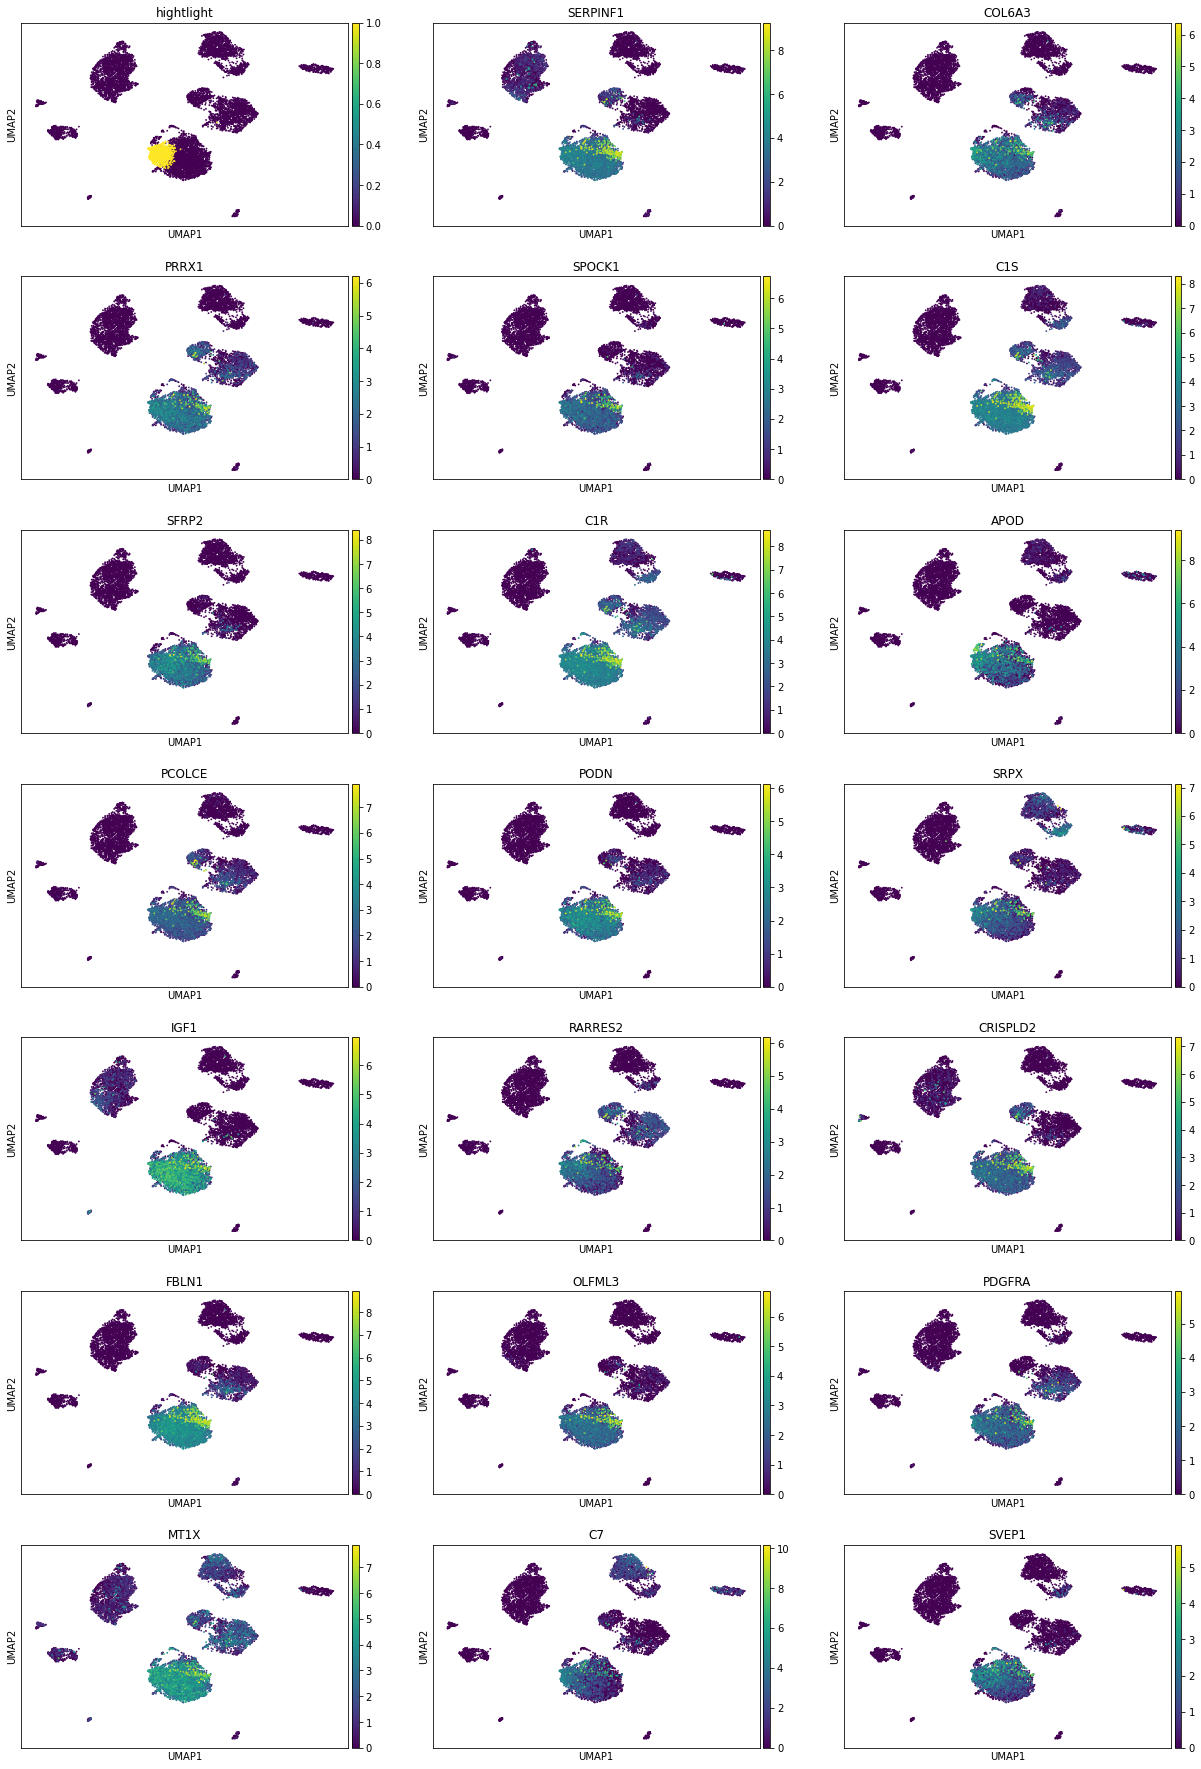

In [24]:
topgenes = list(DE["0"].T[:20].index)
organ_adata.obs["hightlight"] = organ_adata.obs["leiden"] == "0"
sc.pl.umap(
    organ_adata,
    color=["hightlight"] + topgenes,
    ncols=3,
)

You can do this for other clusters as well. Here I plot the top 5 genes for all other clusters

0


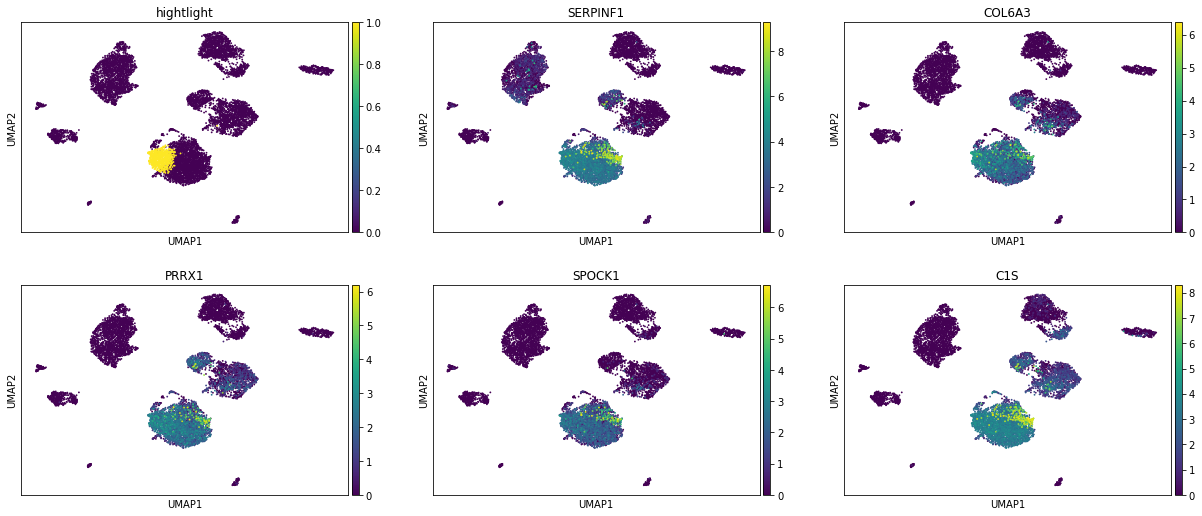

1


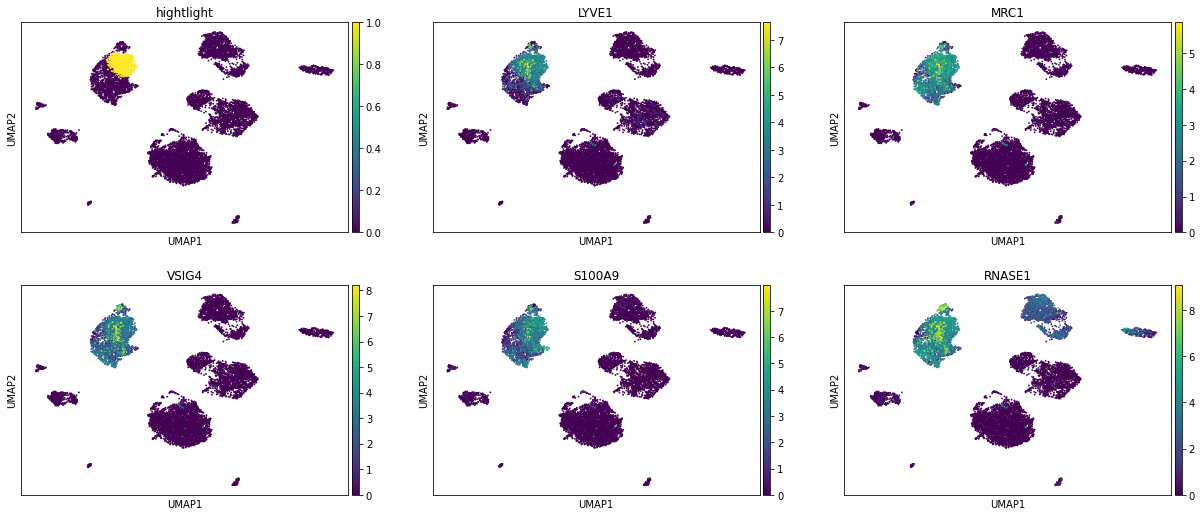

2


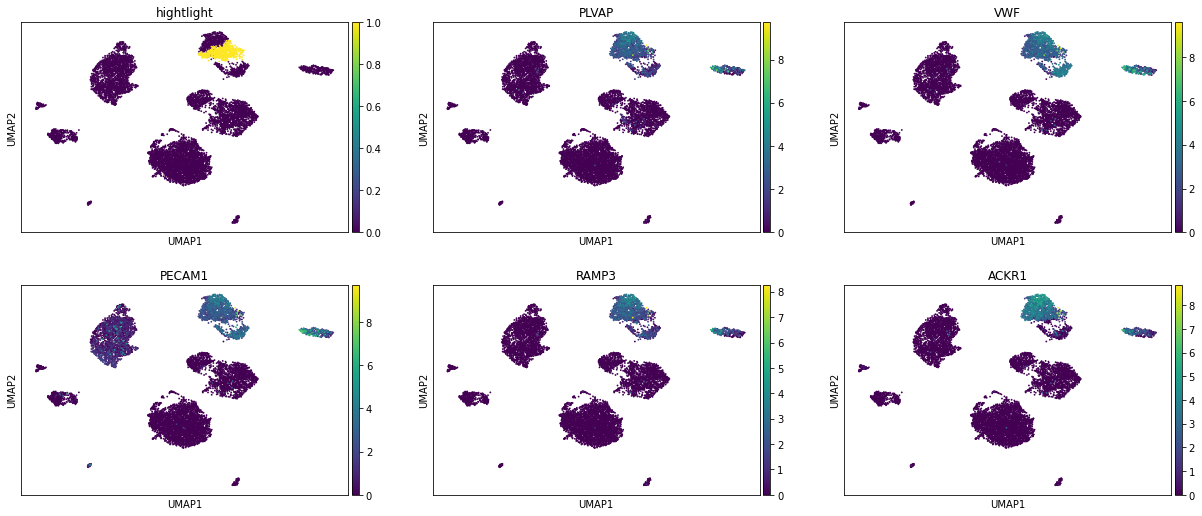

3


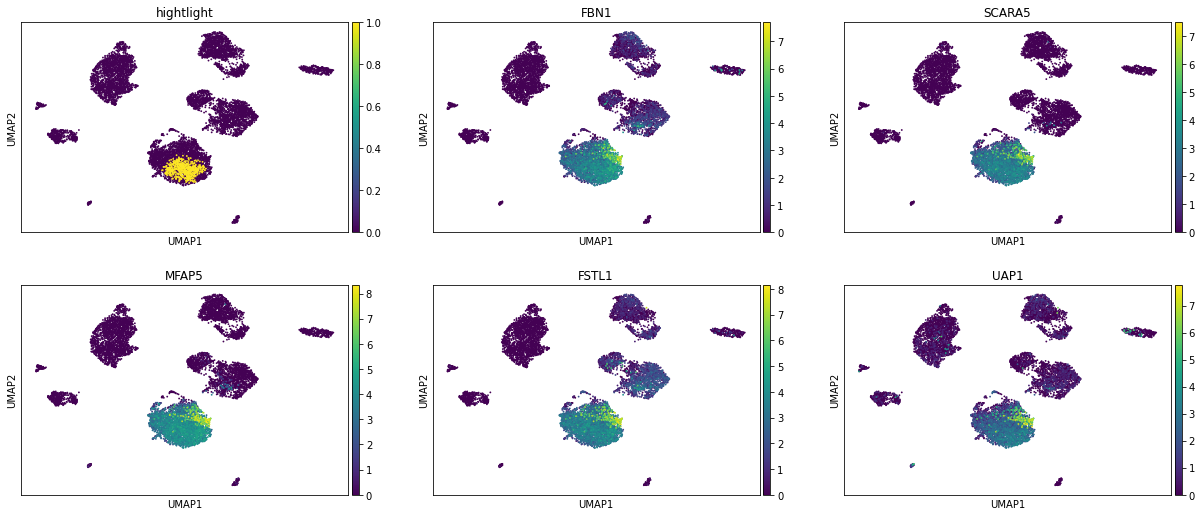

4


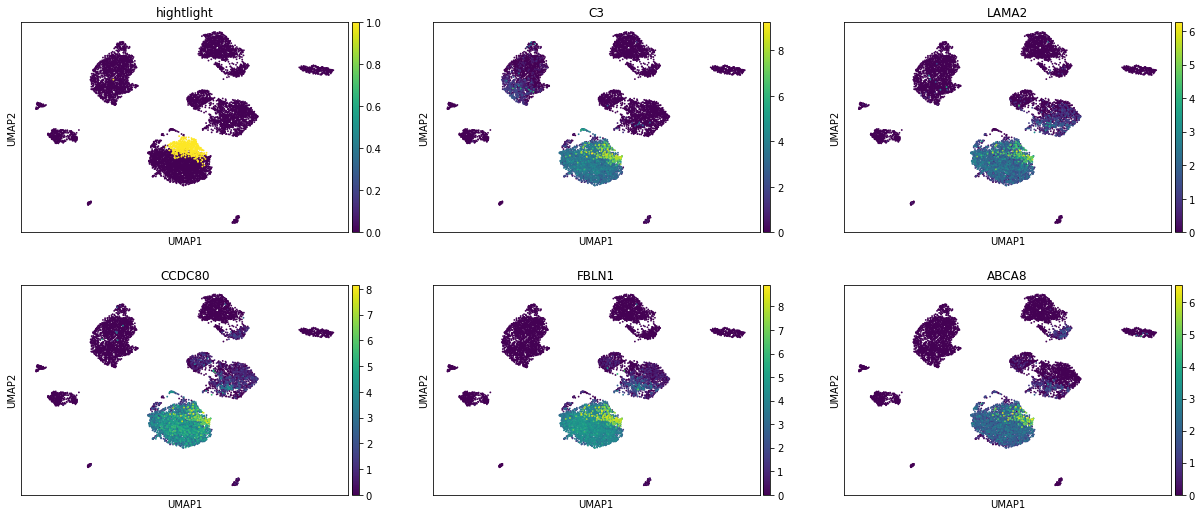

5


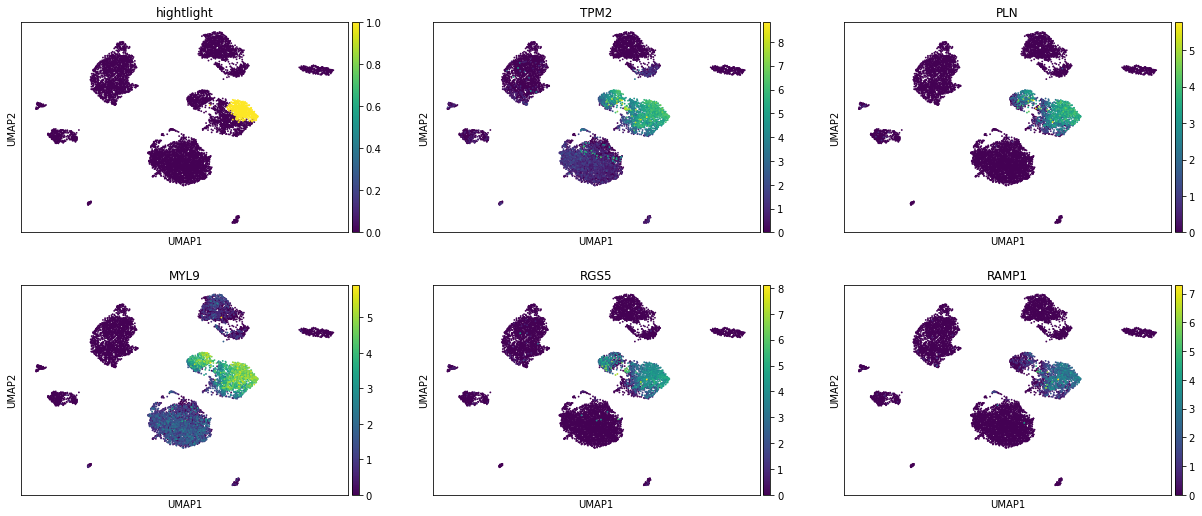

6


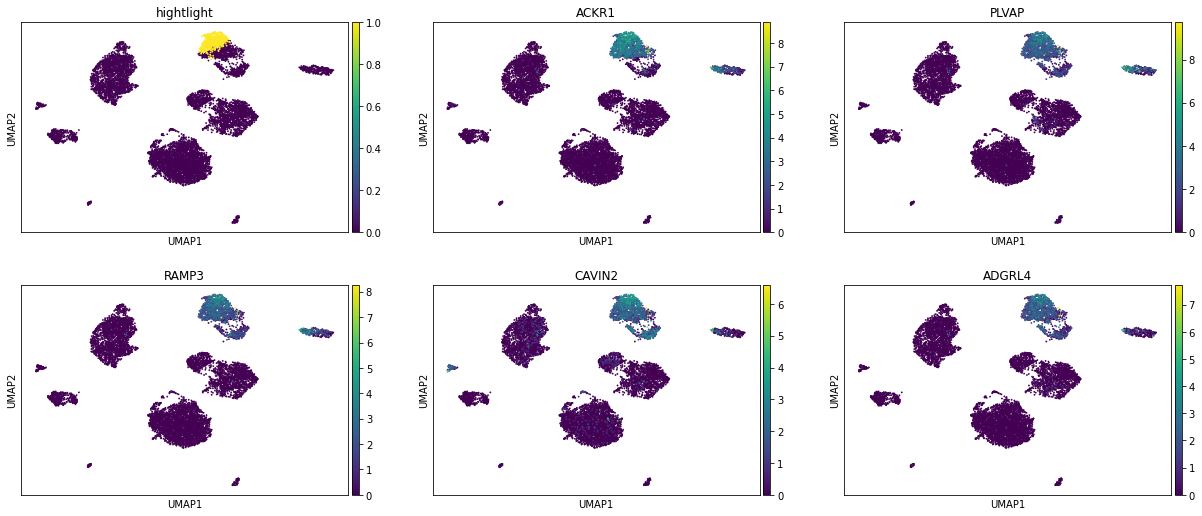

7


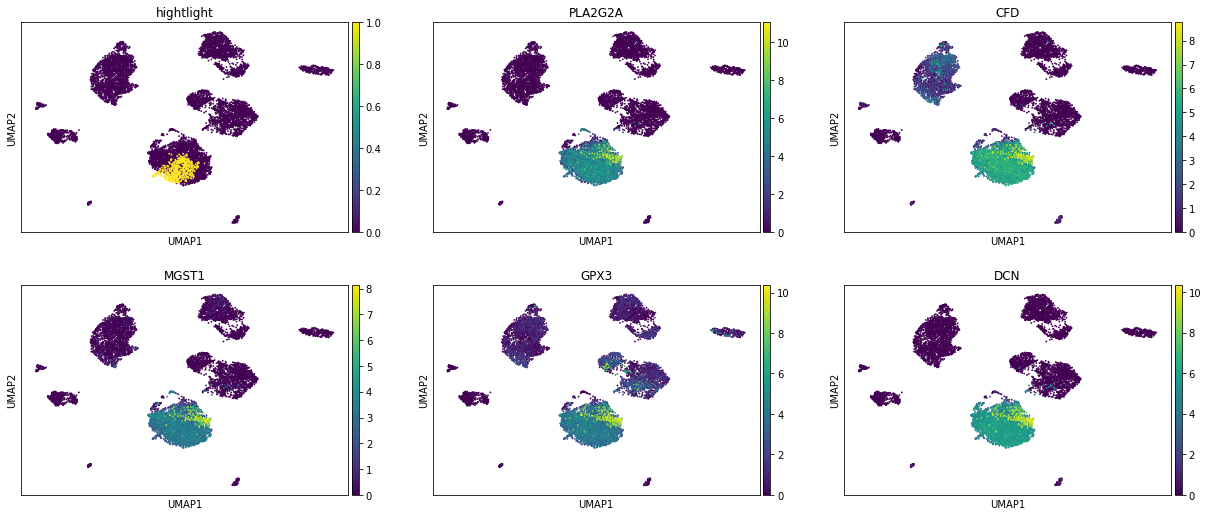

8


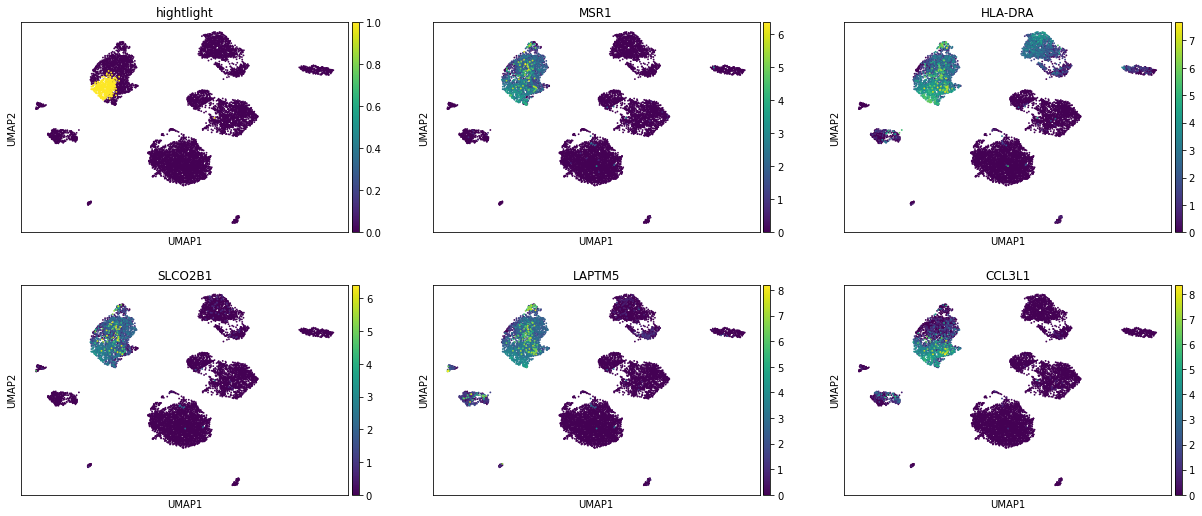

9


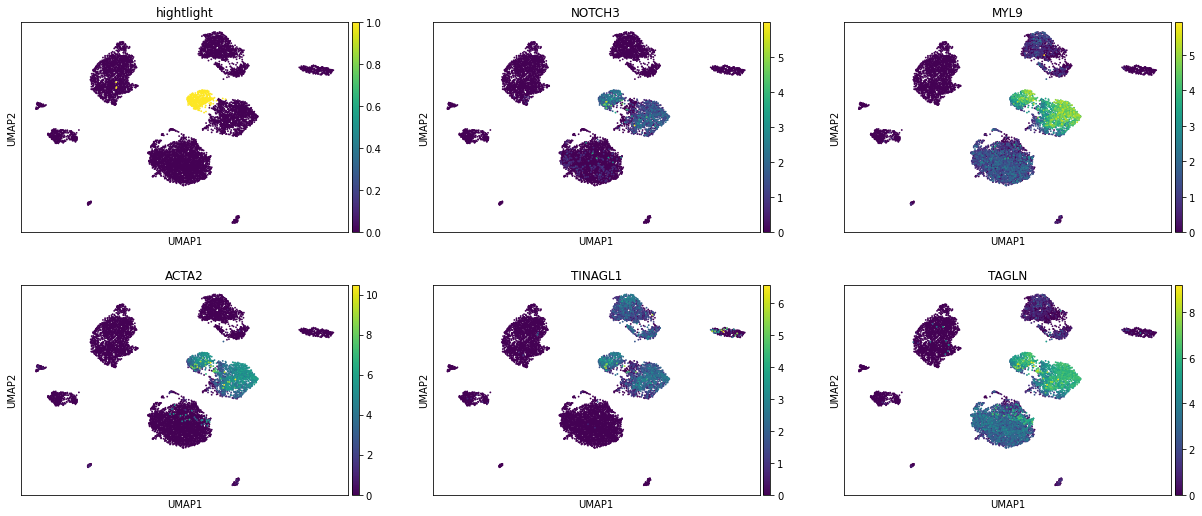

10


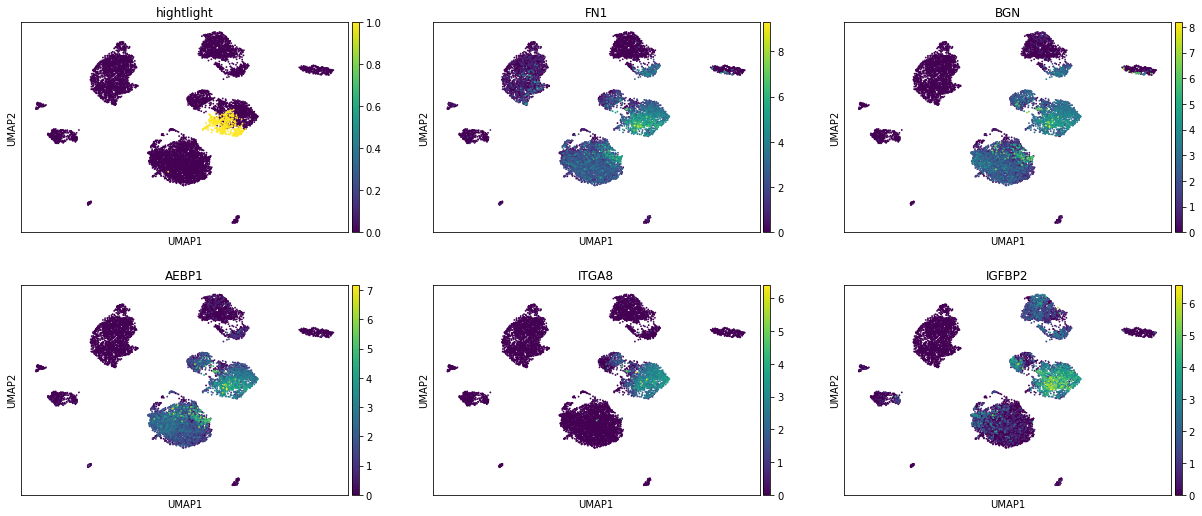

11


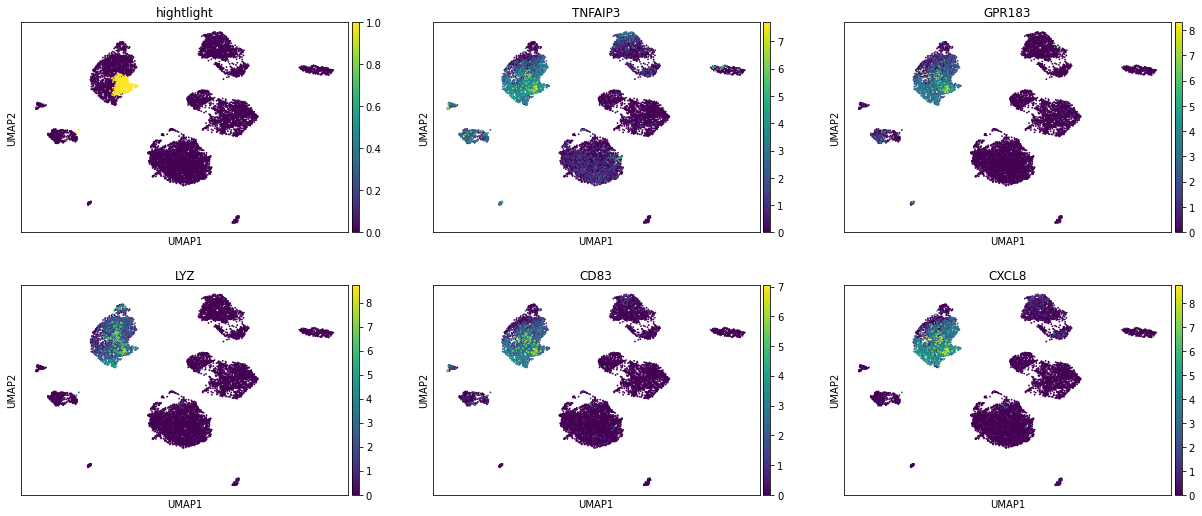

12


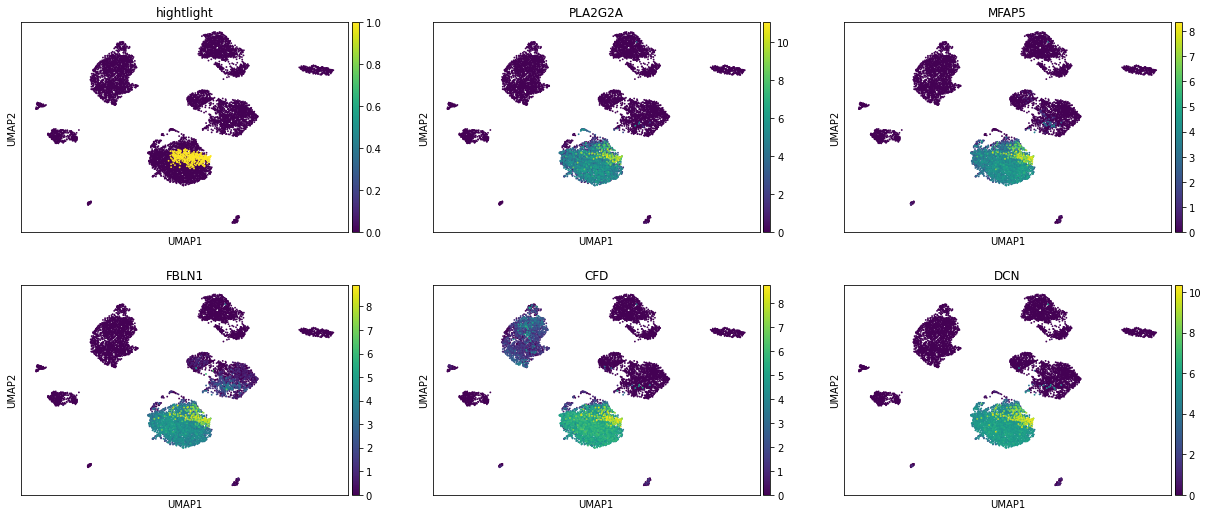

13


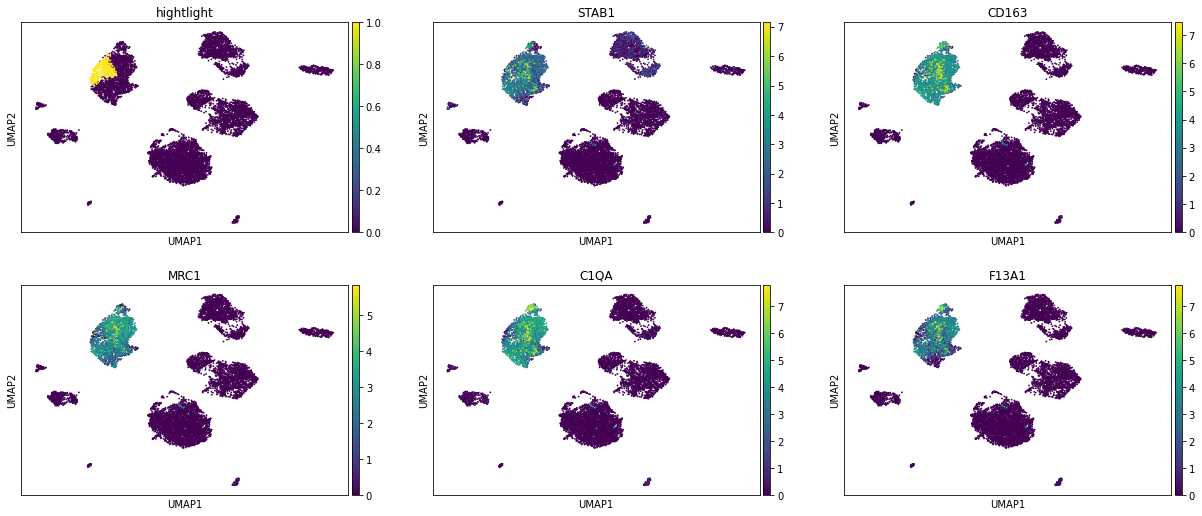

14


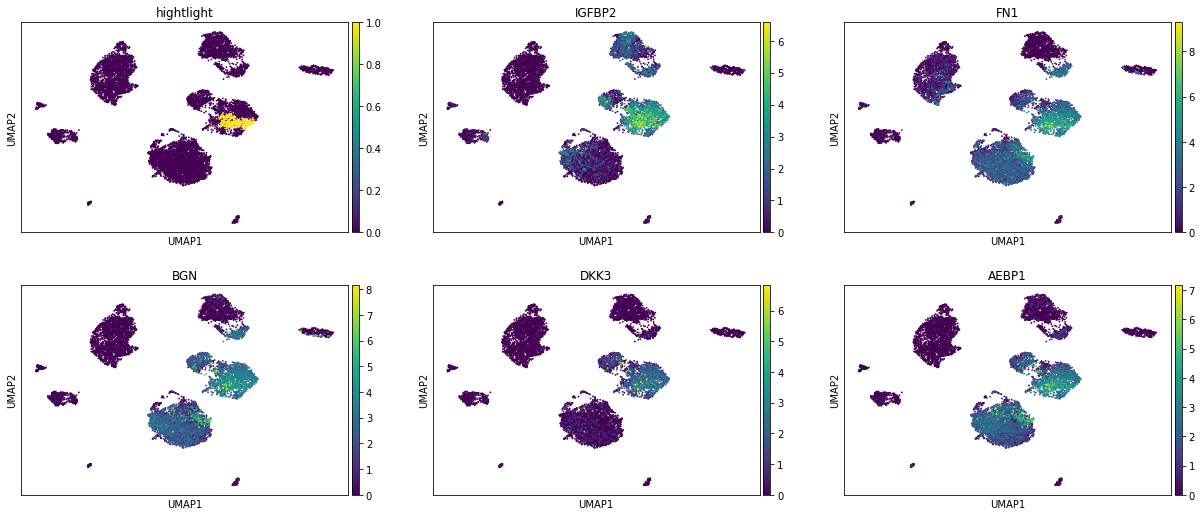

15


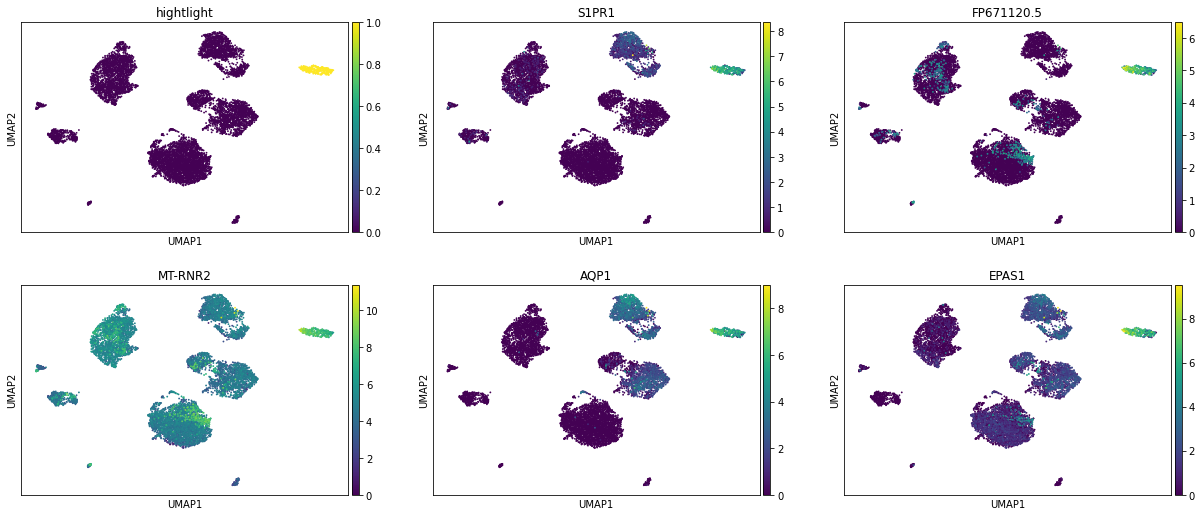

16


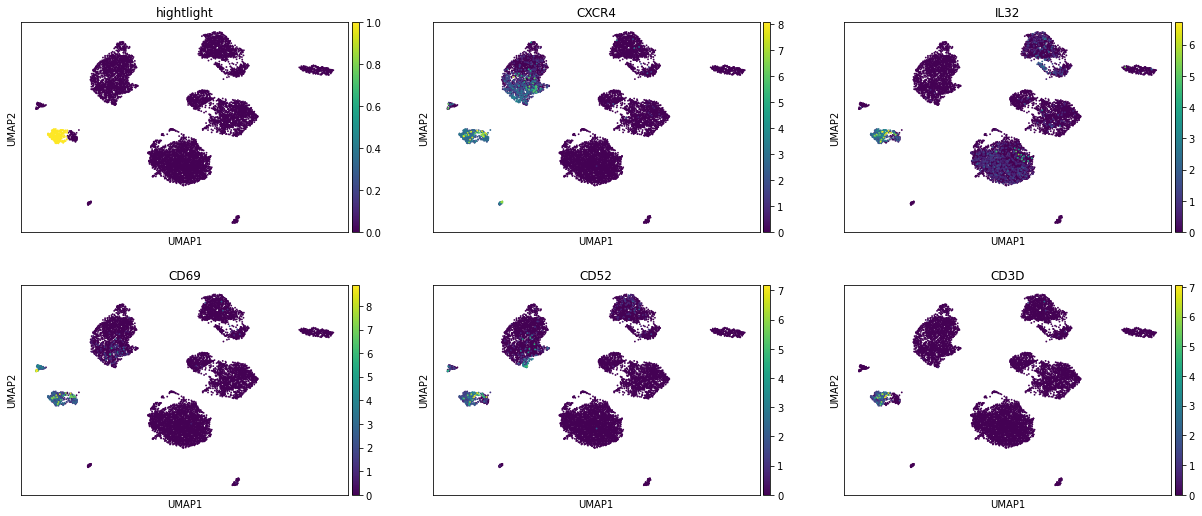

17


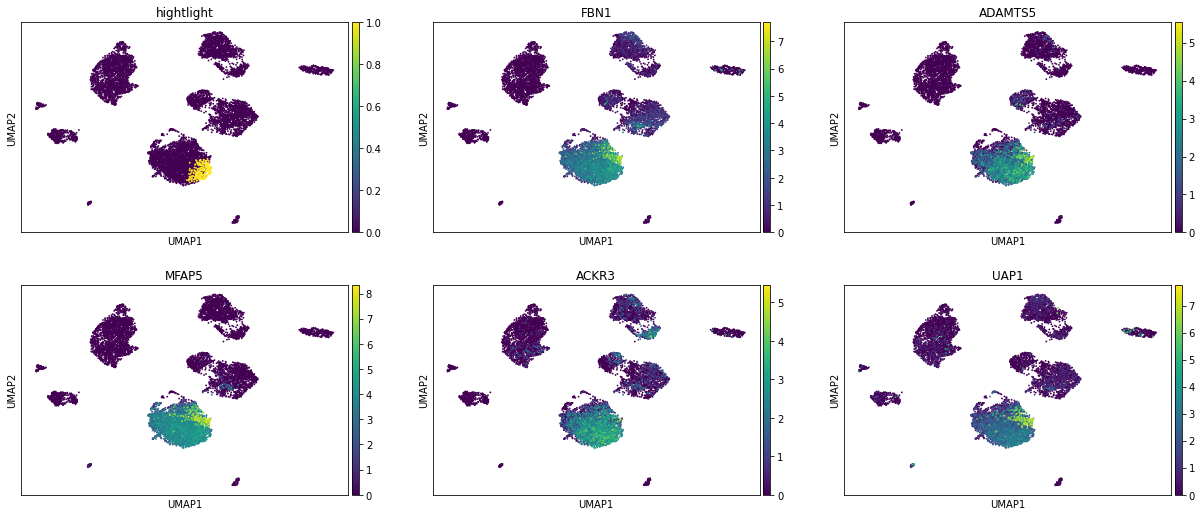

18


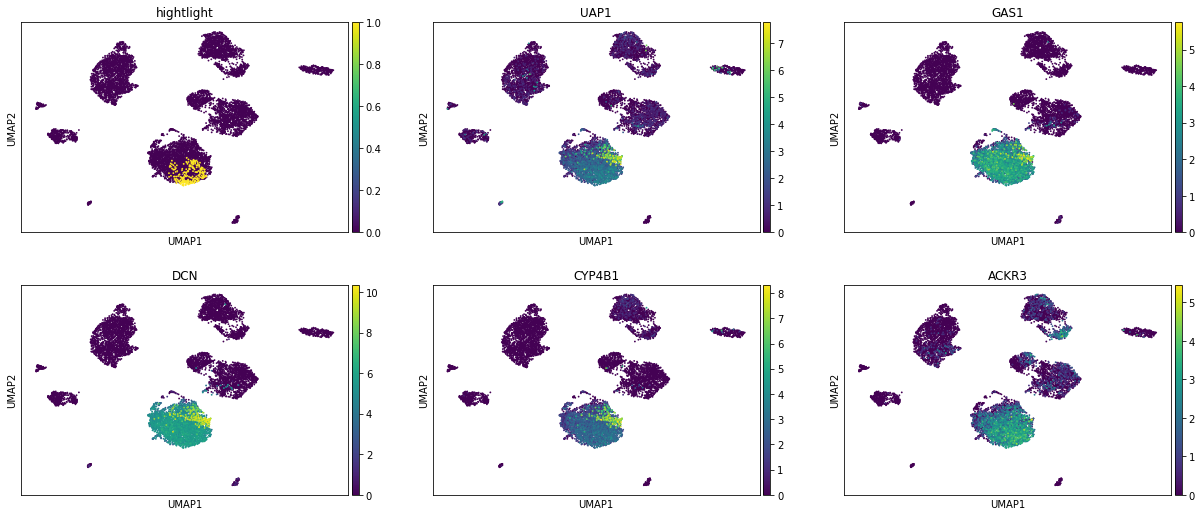

19


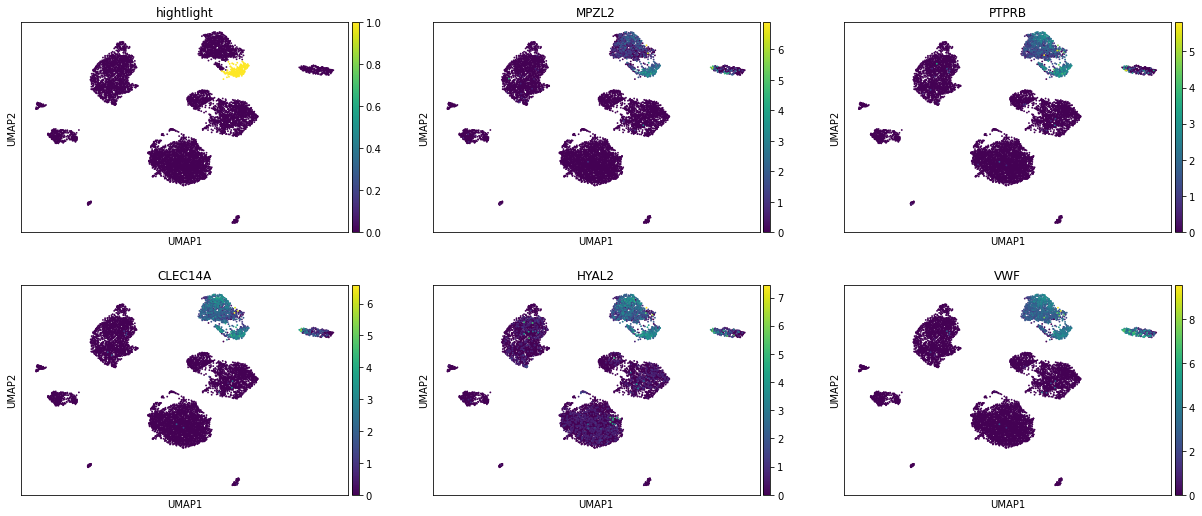

20


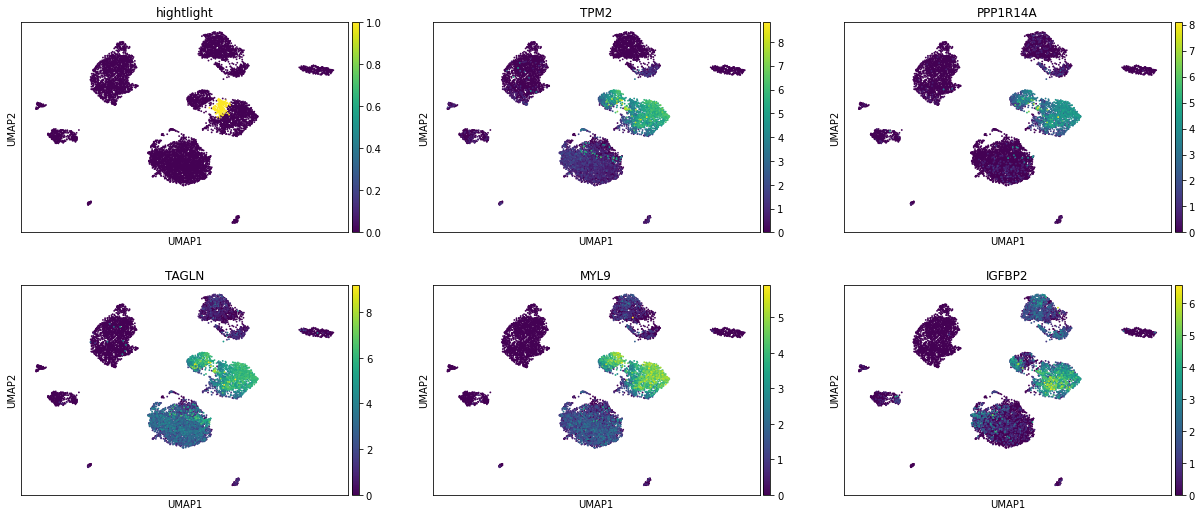

21


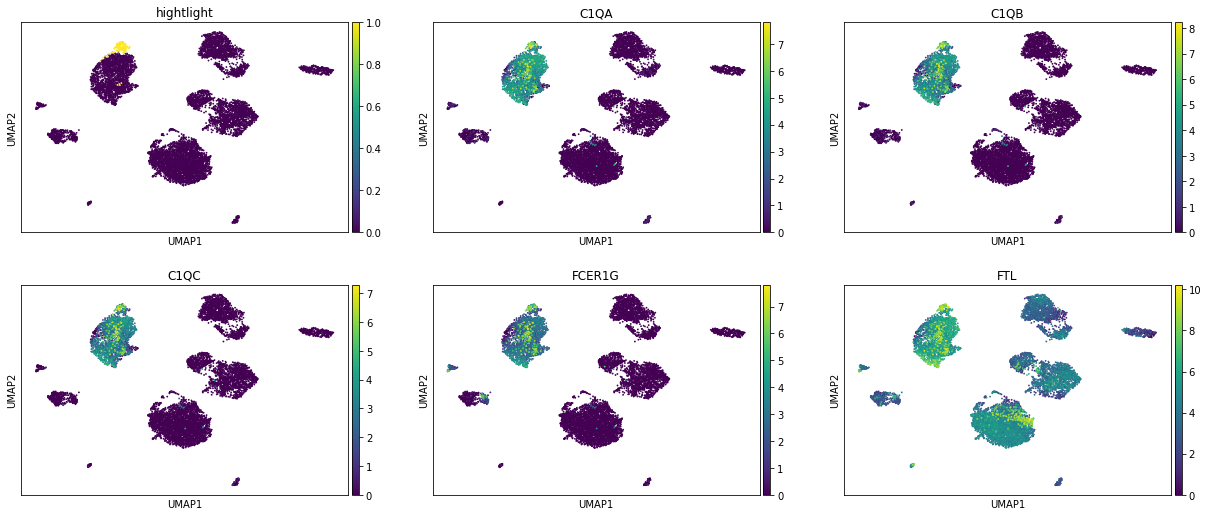

22


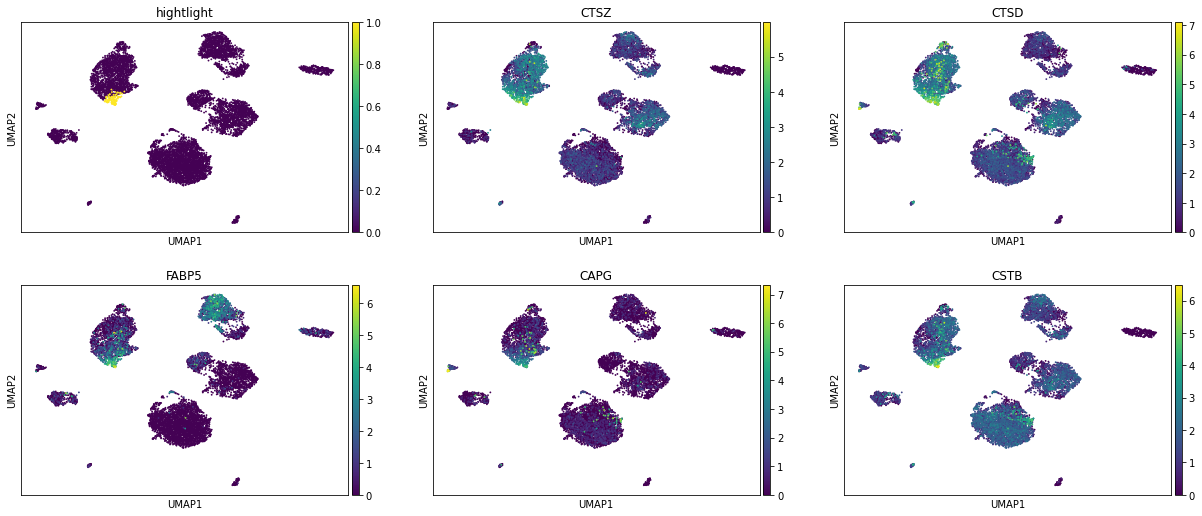

23


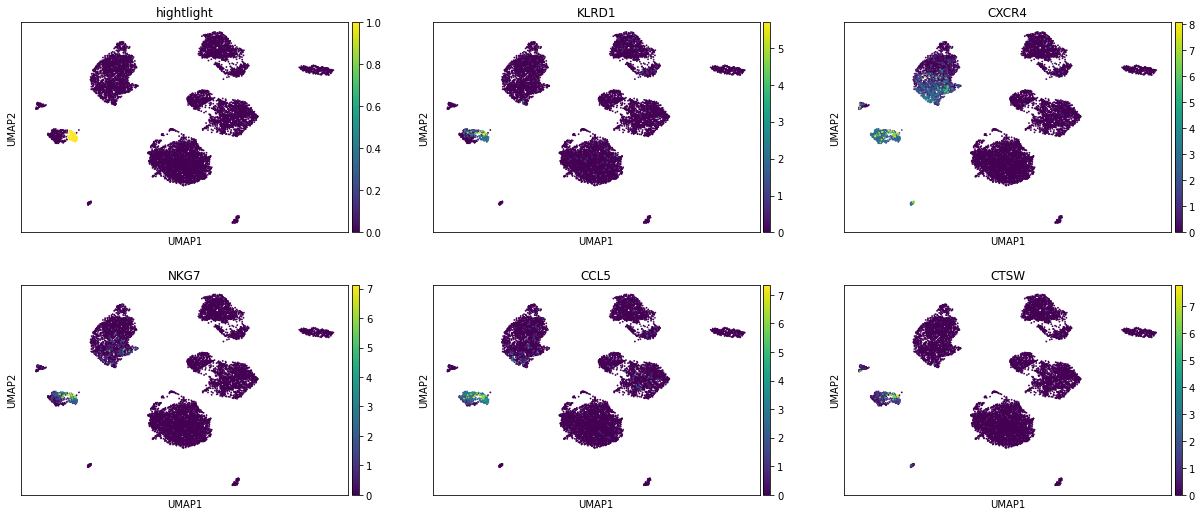

24


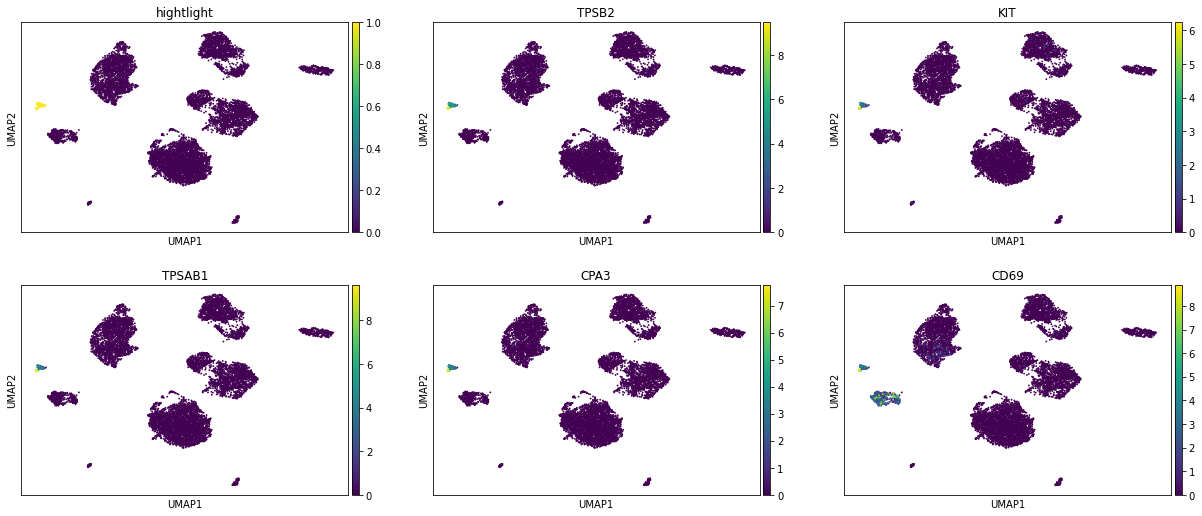

25


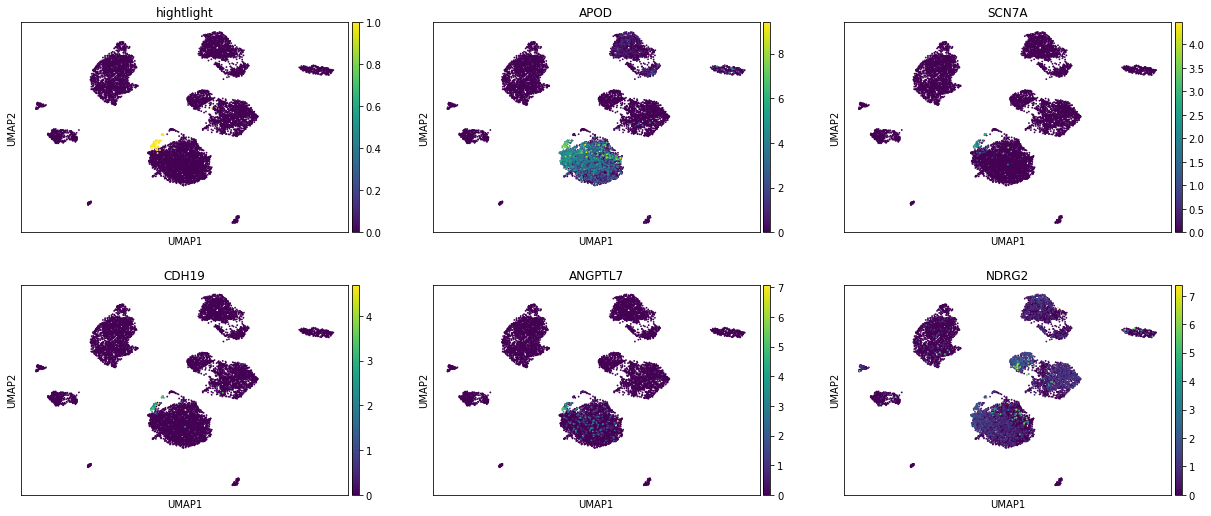

26


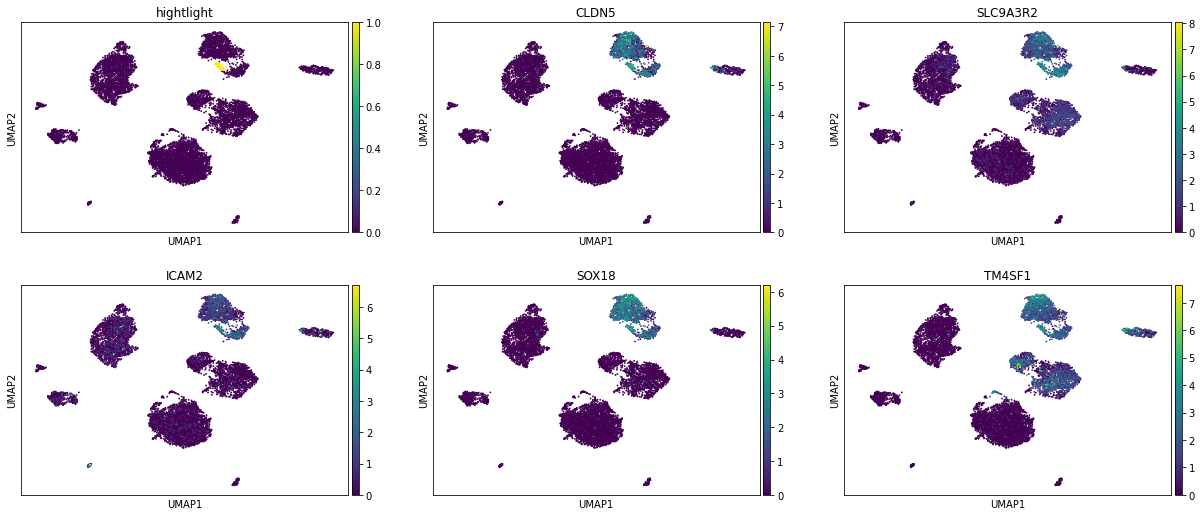

27


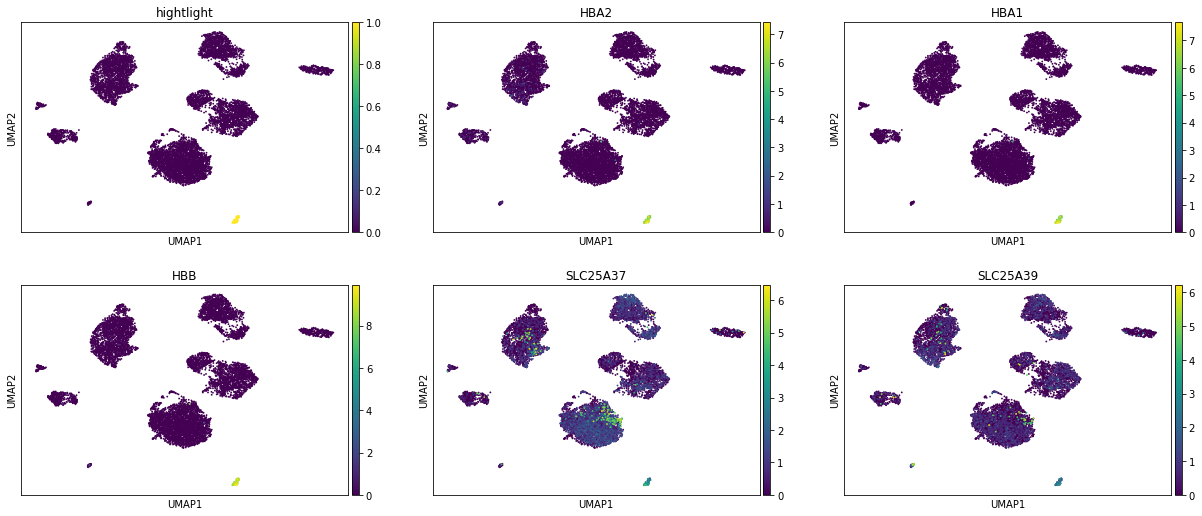

28


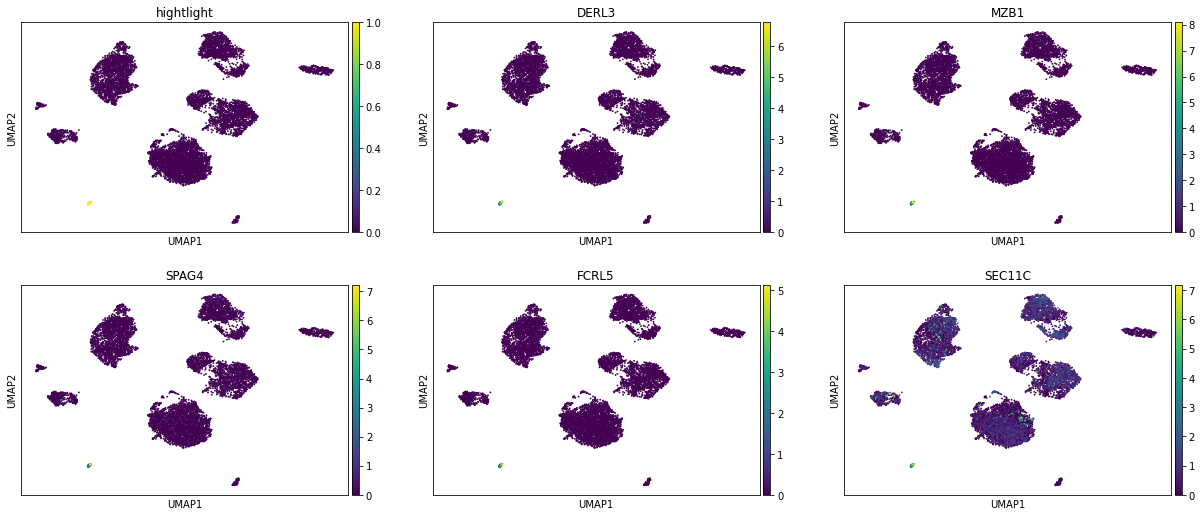

29


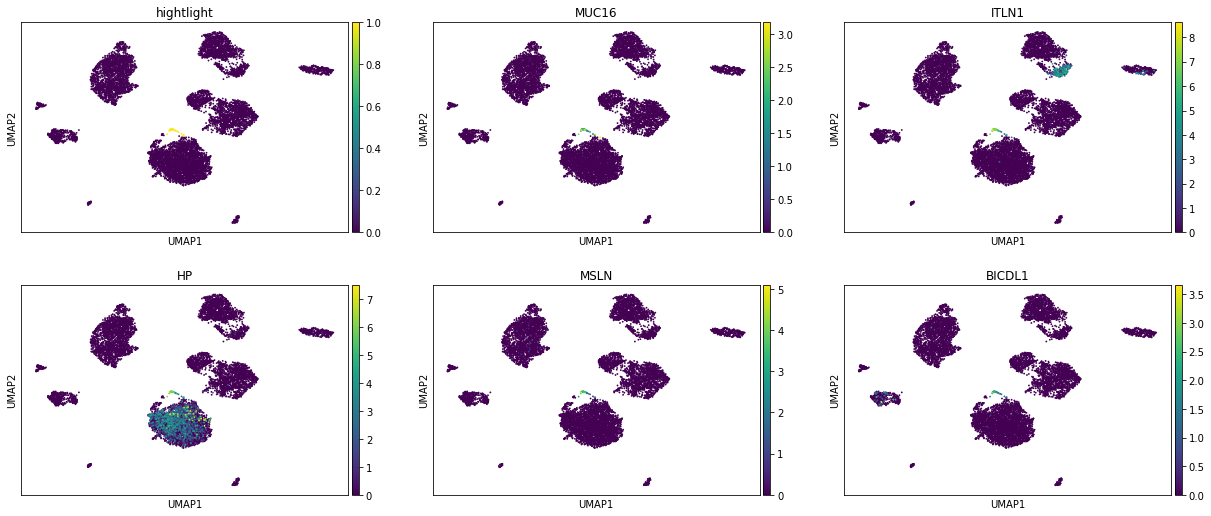

In [25]:
for x in DE.keys():
    print(x)
    topgenes = list(DE[x].T[:5].index)
    organ_adata.obs["hightlight"] = organ_adata.obs["leiden"] == x
    sc.pl.umap(
        organ_adata,
        color=["hightlight"] + topgenes,
        ncols=3,
    )

### The extended DE list can be queried by 

In [26]:
DE["0"].T

wilcoxon_score  log fold change  adjusted pvalue
SERPINF1       34.297207         4.121323    5.084276e-253
COL6A3         32.768597         3.396478    4.857053e-231
PRRX1          32.482800         3.099557    3.660727e-227
SPOCK1         32.251904         3.284850    4.868929e-224
C1S            32.030838         3.430645    4.778911e-221
...                  ...              ...              ...
HLA-DRA       -15.940496       -30.511118     3.806568e-55
RNASE1        -17.298948       -31.252619     6.667224e-65
CD74          -18.613110        -7.545005     4.305489e-75
LRRFIP1       -19.669931        -3.067630     7.895935e-84
SRGN          -22.875849        -5.034421    3.151663e-113

[58870 rows x 3 columns]

# read in cell ontology 

In [27]:
import obonet

ont_dir = "/data/yosef2/users/chenling/TabulaSapiensData/ontology/"
obo = ont_dir + "cl.obo.txt"
f = open(obo, "r")
co = obonet.read_obo(f)
f.close()

celltype_dict = {}
for x in co.nodes:
    celltype_dict[co.nodes[x]['name']] = x



You can look up all T cell by typing celltype_dict['T'] and using tab complete  

In [28]:
celltype_dict['T cell']

'CL:0000084'

You can also look at the names of all subsets of T cell that contains 'CD4' in their names

In [29]:
import networkx as nx


def PrintChildren(co, parent, pattern=""):
    all_children = [x for x in nx.ancestors(co, celltype_dict[parent])]
    return [co.nodes[x]["name"] for x in all_children if pattern in co.nodes[x]["name"]]


PrintChildren(co, "T cell", "CD4")

['CD4-positive, CXCR3-negative, CCR6-negative, alpha-beta T cell',
 'CD4-negative, CD8-negative, alpha-beta intraepithelial T cell',
 'CD4-negative CD8-negative gamma-delta intraepithelial T cell',
 'effector memory CD4-positive, alpha-beta T cell',
 'CD4-positive, CD25-positive, CCR4-positive, alpha-beta regulatory T cell',
 'activated CD4-positive, alpha-beta T cell, human',
 'CD4-positive type I NK T cell secreting interferon-gamma',
 'CD4-negative, CD8-negative type I NK T cell',
 'CD4-positive, alpha-beta T cell',
 'CD2-positive, CD5-positive, CD44-positive alpha-beta intraepithelial T cell',
 'naive thymus-derived CD4-positive, alpha-beta T cell',
 'CD4-positive, alpha-beta thymocyte',
 'activated CD4-positive type I NK T cell',
 'CD4-positive, alpha-beta intraepithelial T cell',
 'CD4-positive, alpha-beta cytotoxic T cell',
 'CD4-intermediate, CD8-positive double-positive thymocyte',
 'effector CD4-positive, alpha-beta T cell',
 'activated CD4-positive, alpha-beta T cell',
 'mat

# manually create mapping between cluster and cell type (this is just an example), and the relevant marker genes that was used to generate this prediction

In [30]:
organ_adata.obs["annotation_oct2020"] = organ_adata.obs["leiden"].copy()
cluster_mapping = {"0": "T cell"}
cluster_markers = {"0": ["CXCR4", "CD3D", "IL7R", "IL32"]}

This cell will automatically replace the leiden cluster names with cell type annotations

In [31]:
for l in cluster_mapping.keys():
    organ_adata.obs["annotation_oct2020"].replace(l, cluster_mapping[l], inplace=True)
    display(DE[l][cluster_markers[l]])

CXCR4       CD3D       IL7R      IL32
wilcoxon_score  -5.814772e+00  -1.183005  -1.127865  4.355062
log fold change -2.831137e+01 -25.475849 -25.579840  0.352827
adjusted pvalue  1.177332e-07   1.000000   1.000000  0.000187

# Visualize the results of the manual annotation

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



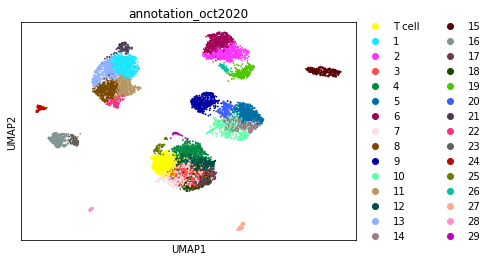

In [32]:
sc.pl.umap(
    organ_adata,
    color=["annotation_oct2020"],
    ncols=3,
)

# manually create mapping between cell type and compartment (this is just an example)

In [33]:
organ_adata.obs["compartment_oct2020"] = organ_adata.obs["annotation_oct2020"].copy()
compartment_mapping = {"T cell": "Immune"}

This cell will automatically replace the leiden cluster names with cell type annotations

In [34]:
for c in compartment_mapping.keys():
    organ_adata.obs["compartment_oct2020"].replace(
        c, compartment_mapping[c], inplace=True
    )

# Visualize the results of the new compartment splitting

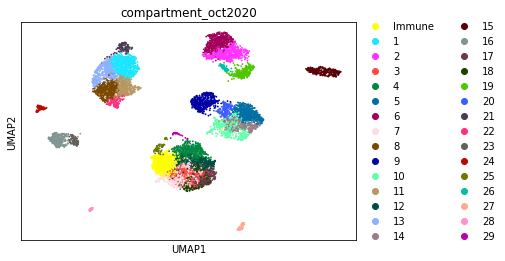

In [35]:
sc.pl.umap(
    organ_adata,
    color=["compartment_oct2020"],
    ncols=3,
)

# save data

In [36]:
organ_adata.write_h5ad(
    data_path + "decontX/organ_data/Pilot1_Pilot2.decontX.%s.h5ad" % organ
)